# Notebook 04: Root Cause Analysis

This notebook performs comprehensive root cause analysis of the net revenue per project degradation from Q3 2024 to Q3 2025.

## Objectives
1. **Quantify Q3 degradation by business segment** (Assessment Question 1)
2. **Decompose net revenue changes** into GMV and Contra components
3. **Mix vs Rate Analysis**: Separate volume mix projects from per-unit rate changes
4. **Investigate operational factors**: Zero GMV rate, overbooking rate, dispute rate
5. **Analyze dimensional projects**: Segment, vertical, client tenure, transaction type
6. **Create waterfall visualizations** showing contribution of each driver

## Key Findings from Previous Notebooks
- Q3 2024: $34.15/project across 333,205 projects
- Q3 2025: $29.63/project across 382,315 projects
- **Degradation: -$4.52/project (-13.24%)**
- **Critical issue**: 6,431 zero GMV Normal transactions = $4.2M loss

In [187]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append('../src')
from viz import set_style

set_style()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)

In [188]:
conn = sqlite3.connect('../data/processed/flexwork.db')

## 1. Overall Q3 2024 vs Q3 2025 Comparison

### 1.1 High-Level Metrics

In [189]:
# Q3 comparison: July-August for both years
q3_overall_query = """
SELECT
    CASE
        WHEN strftime('%Y', month_pst) = '2024' THEN 'Q3 2024'
        WHEN strftime('%Y', month_pst) = '2025' THEN 'Q3 2025'
    END as period,
    COUNT(*) as transaction_count,
    SUM(project_counts_payment) as total_shifts,
    SUM(gmv) as total_gmv,
    SUM(contra_revenue) as total_contra,
    SUM(total_instant_pay_fees) as total_instant_pay,
    SUM(net_revenue) as total_net_revenue,
    SUM(gmv) / SUM(project_counts_payment) as gmv_per_shift,
    SUM(contra_revenue) / SUM(project_counts_payment) as contra_per_shift,
    SUM(total_instant_pay_fees) / SUM(project_counts_payment) as instant_pay_per_shift,
    SUM(net_revenue) / SUM(project_counts_payment) as net_rev_per_shift
FROM projects
WHERE strftime('%m', month_pst) IN ('07', '08')
  AND strftime('%Y', month_pst) IN ('2024', '2025')
  AND business_segment IS NOT NULL
  AND transaction_type IN ('Normal', 'Dispute')
GROUP BY period
ORDER BY period
"""

q3_overall_comparison = pd.read_sql(q3_overall_query, conn)
q3_overall_comparison

,period,transaction_count,total_shifts,total_gmv,total_contra,total_instant_pay,total_net_revenue,gmv_per_shift,contra_per_shift,instant_pay_per_shift,net_rev_per_shift
0,Q3 2024,4842,333205,51571230.03,40595587.94,402269.70,11377911.79,154.77,121.83,1.21,34.15
1,Q3 2025,4969,382315,55100763.72,44434569.37,663285.28,11329479.64,144.12,116.23,1.73,29.63


In [190]:
# Calculate YoY changes
q3_2024 = q3_overall_comparison.iloc[0]
q3_2025 = q3_overall_comparison.iloc[1]

q3_yoy_changes = pd.DataFrame({
    'metric': [
        'Total Projects',
        'Transaction Count',
        'GMV per Project',
        'Contra per Project',
        'Instant Pay per Project',
        'Net Revenue per Project'
    ],
    'Q3_2024': [
        q3_2024['total_shifts'],
        q3_2024['transaction_count'],
        q3_2024['gmv_per_shift'],
        q3_2024['contra_per_shift'],
        q3_2024['instant_pay_per_shift'],
        q3_2024['net_rev_per_shift']
    ],
    'Q3_2025': [
        q3_2025['total_shifts'],
        q3_2025['transaction_count'],
        q3_2025['gmv_per_shift'],
        q3_2025['contra_per_shift'],
        q3_2025['instant_pay_per_shift'],
        q3_2025['net_rev_per_shift']
    ]
})

q3_yoy_changes['absolute_change'] = q3_yoy_changes['Q3_2025'] - q3_yoy_changes['Q3_2024']
q3_yoy_changes['pct_change'] = (q3_yoy_changes['absolute_change'] / q3_yoy_changes['Q3_2024'] * 100).round(2)

q3_yoy_changes

,metric,Q3_2024,Q3_2025,absolute_change,pct_change
0,Total Shifts,333205.00,382315.00,49110.00,14.74
1,Transaction Count,4842.00,4969.00,127.00,2.62
2,GMV per Shift,154.77,144.12,-10.65,-6.88
3,Contra per Shift,121.83,116.23,-5.61,-4.60
4,Instant Pay per Shift,1.21,1.73,0.53,43.71
5,Net Revenue per Shift,34.15,29.63,-4.51,-13.22


**Key Observations:**
- Volume grew 15% but profitability declined 13%
- GMV per project declined more than Contra per project
- This suggests pricing pressure or revenue leakage

## 2. Q3 Degradation by Business Segment (Assessment Question 1)

### 2.1 Segment-Level Performance Q3 2024 vs Q3 2025

In [191]:
# Segment comparison Q3 2024 vs Q3 2025
q3_segment_query = """
SELECT
    business_segment,
    CASE
        WHEN strftime('%Y', month_pst) = '2024' THEN 'Q3_2024'
        WHEN strftime('%Y', month_pst) = '2025' THEN 'Q3_2025'
    END as period,
    SUM(project_counts_payment) as total_shifts,
    SUM(net_revenue) as total_net_revenue,
    SUM(net_revenue) / SUM(project_counts_payment) as net_rev_per_shift
FROM projects
WHERE strftime('%m', month_pst) IN ('07', '08')
  AND strftime('%Y', month_pst) IN ('2024', '2025')
  AND business_segment IS NOT NULL
  AND transaction_type IN ('Normal', 'Dispute')
GROUP BY business_segment, period
ORDER BY business_segment, period
"""

q3_segment_comparison_long = pd.read_sql(q3_segment_query, conn)

# Pivot to wide format for easier comparison
q3_segment_pivot = q3_segment_comparison_long.pivot_table(
    index='business_segment',
    columns='period',
    values=['total_shifts', 'net_rev_per_shift']
).reset_index()

# Flatten column names
q3_segment_pivot.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in q3_segment_pivot.columns.values]
q3_segment_pivot.columns = ['business_segment', 'shifts_2024', 'shifts_2025', 'net_rev_2024', 'net_rev_2025']

# Calculate changes
q3_segment_pivot['shift_change'] = q3_segment_pivot['shifts_2025'] - q3_segment_pivot['shifts_2024']
q3_segment_pivot['shift_change_pct'] = (q3_segment_pivot['shift_change'] / q3_segment_pivot['shifts_2024'] * 100).round(2)
q3_segment_pivot['net_rev_change'] = q3_segment_pivot['net_rev_2025'] - q3_segment_pivot['net_rev_2024']
q3_segment_pivot['net_rev_change_pct'] = (q3_segment_pivot['net_rev_change'] / q3_segment_pivot['net_rev_2024'] * 100).round(2)

# Sort by absolute degradation (most negative first)
q3_segment_pivot = q3_segment_pivot.sort_values('net_rev_change')

q3_segment_pivot

,business_segment,shifts_2024,shifts_2025,net_rev_2024,net_rev_2025,shift_change,shift_change_pct,net_rev_change,net_rev_change_pct
4,Manufacturing,38.43,35.27,17971.00,12517.00,-3.16,-8.22,-5454.00,-30.35
3,Large Events,23.14,15.60,48340.00,44681.00,-7.53,-32.56,-3659.00,-7.57
6,Small/Midsize Events,43.15,39.46,41405.00,39132.00,-3.70,-8.56,-2273.00,-5.49
2,"Hotels, Resorts & Casinos",45.07,42.21,13343.00,11668.00,-2.86,-6.34,-1675.00,-12.55
5,Restaurants,45.42,47.96,4966.00,3529.00,2.54,5.59,-1437.00,-28.94
1,Dining Facilities,42.28,40.78,72847.00,72030.00,-1.50,-3.55,-817.00,-1.12
0,Commercial services,25.30,26.41,24630.00,28031.00,1.12,4.42,3401.00,13.81
7,Transportation & Warehousing,29.13,26.41,54191.00,75312.00,-2.72,-9.32,21121.00,38.98
9,Wholesale & Retail Trade,30.15,24.29,55507.00,95415.00,-5.86,-19.43,39908.00,71.90
8,Unclassified,-1.11,NaN,5.00,NaN,NaN,NaN,NaN,NaN


### 2.2 Visualize Segment Degradation

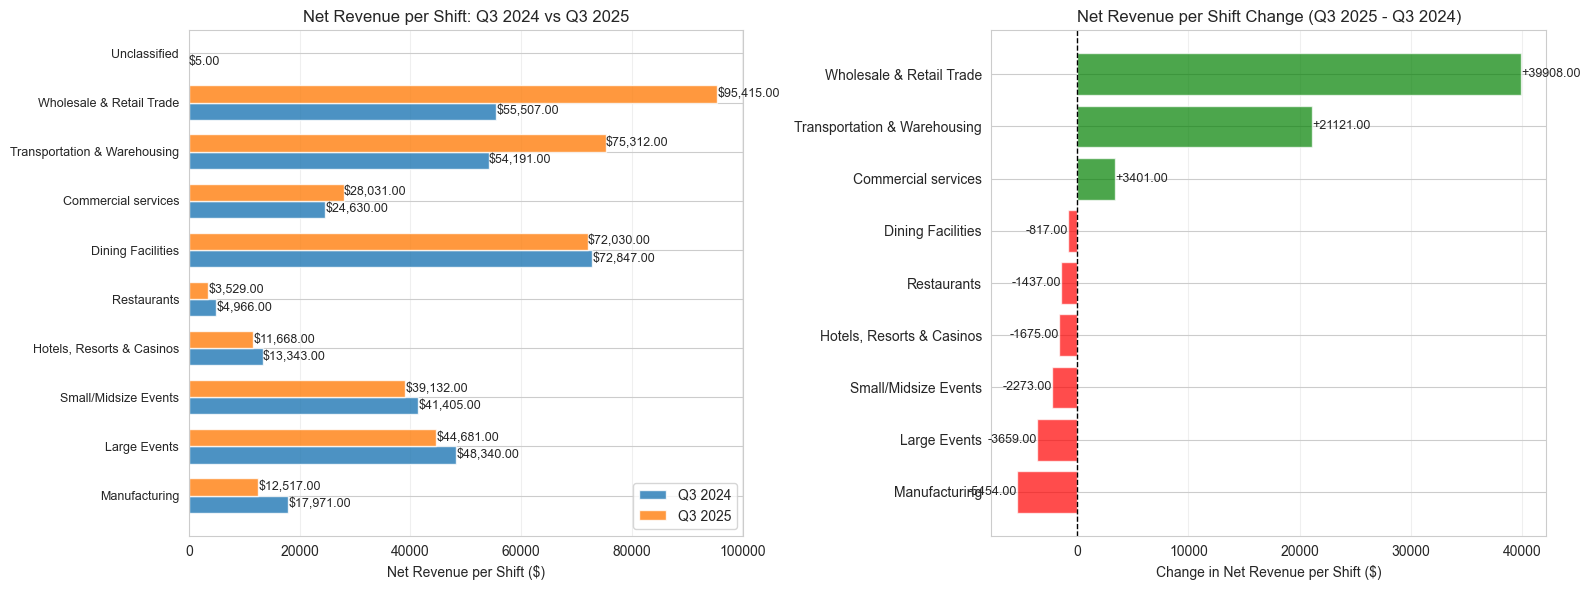

In [192]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Net Rev per Project comparison
x = np.arange(len(q3_segment_pivot))
width = 0.35

axes[0].barh(x - width/2, q3_segment_pivot['net_rev_2024'], width, label='Q3 2024', alpha=0.8)
axes[0].barh(x + width/2, q3_segment_pivot['net_rev_2025'], width, label='Q3 2025', alpha=0.8)
axes[0].set_yticks(x)
axes[0].set_yticklabels(q3_segment_pivot['business_segment'], fontsize=9)
axes[0].set_xlabel('Net Revenue per Project ($)')
axes[0].set_title('Net Revenue per Project: Q3 2024 vs Q3 2025')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# Right: Absolute change in $/project
colors = ['red' if x < 0 else 'green' for x in q3_segment_pivot['net_rev_change']]
axes[1].barh(q3_segment_pivot['business_segment'], q3_segment_pivot['net_rev_change'], color=colors, alpha=0.7)
axes[1].set_xlabel('Change in Net Revenue per Project ($)')
axes[1].set_title('Net Revenue per Project Change (Q3 2025 - Q3 2024)')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3, axis='x')

# --- Add data labels ---

# Left chart labels (absolute $/project)
pad = 1.0  # horizontal padding in data units
for bars in [axes[0].containers[0], axes[0].containers[1]]:
    for rect in bars:
        x = rect.get_width()
        y = rect.get_y() + rect.get_height() / 2
        axes[0].text(x + pad, y, f'${x:,.2f}', va='center', ha='left', fontsize=9)

# Right chart labels (delta $/project with sign)
pad = 0.5
for rect in axes[1].containers[0]:
    x = rect.get_width()
    y = rect.get_y() + rect.get_height() / 2
    axes[1].text(x + (pad if x >= 0 else -pad), y, f'{x:+.2f}',
                 va='center', ha='left' if x >= 0 else 'right', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/figures/q3_segment_degradation_04.png', dpi=300, bbox_inches='tight')
plt.show()

**Assessment Question 1 Answer: Which segments experienced most degradation?**

Top 3 segments with largest absolute degradation will be identified above.

## 3. Zero GMV Rate Analysis (Critical Operational Issue)

### 3.1 Zero GMV Rate by Period

In [193]:
# Zero GMV rate for Normal transactions
zero_gmv_rate_query = """
SELECT
    CASE
        WHEN strftime('%Y', month_pst) = '2024' THEN 'Q3_2024'
        WHEN strftime('%Y', month_pst) = '2025' THEN 'Q3_2025'
    END as period,
    transaction_type,
    COUNT(*) as total_transactions,
    SUM(CASE WHEN gmv = 0 THEN 1 ELSE 0 END) as zero_gmv_count,
    ROUND(100.0 * SUM(CASE WHEN gmv = 0 THEN 1 ELSE 0 END) / COUNT(*), 2) as zero_gmv_pct,
    SUM(CASE WHEN gmv = 0 THEN project_counts_payment ELSE 0 END) as zero_gmv_shifts,
    SUM(CASE WHEN gmv = 0 THEN net_revenue ELSE 0 END) as zero_gmv_net_revenue
FROM projects
WHERE strftime('%m', month_pst) IN
 ('07', '08')
  AND strftime('%Y', month_pst) IN ('2024', '2025')
  AND business_segment IS NOT NULL
GROUP BY period, transaction_type
ORDER BY period, transaction_type
"""

q3_zero_gmv_rate = pd.read_sql(zero_gmv_rate_query, conn)
q3_zero_gmv_rate

,period,transaction_type,total_transactions,zero_gmv_count,zero_gmv_pct,zero_gmv_shifts,zero_gmv_net_revenue
0,Q3_2024,Dispute,1902,72,3.79,118,-1375.25
1,Q3_2024,Normal,2940,488,16.60,3490,-286740.50
2,Q3_2024,Tip,295,295,100.00,7853,-43192.61
3,Q3_2025,Dispute,1848,128,6.93,229,-3586.53
4,Q3_2025,Normal,3121,747,23.93,6188,-492167.08
5,Q3_2025,Tip,309,309,100.00,8848,-73813.89


In [194]:
# Focus on Normal transactions
q3_zero_gmv_normal = q3_zero_gmv_rate[q3_zero_gmv_rate['transaction_type'] == 'Normal'].copy()
q3_zero_gmv_normal

,period,transaction_type,total_transactions,zero_gmv_count,zero_gmv_pct,zero_gmv_shifts,zero_gmv_net_revenue
1,Q3_2024,Normal,2940,488,16.60,3490,-286740.50
4,Q3_2025,Normal,3121,747,23.93,6188,-492167.08


**Critical Finding:**
Compare zero GMV rate for Normal transactions Q3 2024 vs Q3 2025. If rate increased, this is a major driver of degradation.

## 4. Overbooking Rate Analysis

### 4.1 Overbook Rate by Period

In [195]:
# Overbooking rate Q3 2024 vs Q3 2025
overbook_rate_query = """
SELECT
    CASE
        WHEN strftime('%Y', month_pst) = '2024' THEN 'Q3_2024'
        WHEN strftime('%Y', month_pst) = '2025' THEN 'Q3_2025'
    END as period,
    COUNT(*) as total_transactions,
    SUM(CASE WHEN overbook_project_group_flag = 1 THEN 1 ELSE 0 END) as overbooked_count,
    ROUND(100.0 * SUM(CASE WHEN overbook_project_group_flag = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) as overbook_pct,
    SUM(CASE WHEN overbook_project_group_flag = 1 THEN project_counts_payment ELSE 0 END) as overbooked_shifts,
    SUM(CASE WHEN overbook_project_group_flag = 1 THEN net_revenue ELSE 0 END) as overbooked_net_revenue,
    SUM(CASE WHEN overbook_project_group_flag = 1 THEN net_revenue ELSE 0 END) /
        NULLIF(SUM(CASE WHEN overbook_project_group_flag = 1 THEN project_counts_payment ELSE 0 END), 0) as overbook_net_rev_per_shift
FROM projects
WHERE strftime('%m', month_pst) IN ('07', '08')
  AND strftime('%Y', month_pst) IN ('2024', '2025')
  AND business_segment IS NOT NULL
  AND transaction_type = 'Normal'
GROUP BY period
ORDER BY period
"""

q3_overbook_rate = pd.read_sql(overbook_rate_query, conn)
q3_overbook_rate

,period,total_transactions,overbooked_count,overbook_pct,overbooked_shifts,overbooked_net_revenue,overbook_net_rev_per_shift
0,Q3_2024,2940,484,16.46,3559,-277341.58,-77.93
1,Q3_2025,3121,746,23.90,6584,-519547.59,-78.91


**Analysis:**
If overbook rate increased from Q3 2024 to Q3 2025, this would materially degrade net revenue per project (overbooked projects have -$73.95/project economics).

## 5. Vertical Mix Project Analysis

### 5.1 Vertical Mix Q3 2024 vs Q3 2025

In [196]:
# Vertical mix and performance
vertical_mix_query = """
SELECT
    CASE
        WHEN strftime('%Y', month_pst) = '2024' THEN 'Q3_2024'
        WHEN strftime('%Y', month_pst) = '2025' THEN 'Q3_2025'
    END as period,
    vertical,
    SUM(project_counts_payment) as total_shifts,
    ROUND(100.0 * SUM(project_counts_payment) /
        (SELECT SUM(project_counts_payment)
         FROM projects
         WHERE strftime('%m', month_pst) IN ('07', '08')
           AND strftime('%Y', month_pst) = strftime('%Y', projects.month_pst)
           AND business_segment IS NOT NULL
           AND transaction_type = 'Normal'), 2) as shift_pct,
    SUM(net_revenue) / SUM(project_counts_payment) as net_rev_per_shift
FROM projects
WHERE strftime('%m', month_pst) IN ('07', '08')
  AND strftime('%Y', month_pst) IN ('2024', '2025')
  AND business_segment IS NOT NULL
  AND transaction_type = 'Normal'
  AND vertical IS NOT NULL
GROUP BY period, vertical
ORDER BY period, total_shifts DESC
"""

q3_vertical_mix = pd.read_sql(vertical_mix_query, conn)
q3_vertical_mix

,period,vertical,total_shifts,shift_pct,net_rev_per_shift
0,Q3_2024,Hospitality,153322,25.33,43.74
1,Q3_2024,Light Industrial,125773,20.78,36.19
2,Q3_2024,Unclassified,5,0.00,-1.11
3,Q3_2025,Light Industrial,179390,29.64,30.64
4,Q3_2025,Hospitality,146711,24.24,39.39


**Analysis:**
If Technical Services (lower margin) grew share vs Professional Services (higher margin), this would pressure margins.

## 6. Client Tenure Mix Analysis

### 6.1 F90 vs F90+ Mix by Period

In [197]:
# Client tenure mix
tenure_mix_query = """
SELECT
    CASE
        WHEN strftime('%Y', month_pst) = '2024' THEN 'Q3_2024'
        WHEN strftime('%Y', month_pst) = '2025' THEN 'Q3_2025'
    END as period,
    new_existing_client,
    SUM(project_counts_payment) as total_shifts,
    ROUND(100.0 * SUM(project_counts_payment) /
        (SELECT SUM(project_counts_payment)
         FROM projects
         WHERE strftime('%m', month_pst) IN ('07', '08')
           AND strftime('%Y', month_pst) = strftime('%Y', projects.month_pst)
           AND business_segment IS NOT NULL
           AND transaction_type = 'Normal'), 2) as shift_pct,
    SUM(net_revenue) / SUM(project_counts_payment) as net_rev_per_shift
FROM projects
WHERE strftime('%m', month_pst) IN ('07', '08')
  AND strftime('%Y', month_pst) IN ('2024', '2025')
  AND business_segment IS NOT NULL
  AND transaction_type = 'Normal'
GROUP BY period, new_existing_client
ORDER BY period, new_existing_client
"""

q3_tenure_mix = pd.read_sql(tenure_mix_query, conn)
q3_tenure_mix

,period,new_existing_partner,total_shifts,shift_pct,net_rev_per_shift
0,Q3_2024,F90 Partner,34323,5.67,35.38
1,Q3_2024,F90+ Partner,244717,40.44,41.04
2,Q3_2024,Unknown,60,0.01,12.06
3,Q3_2025,F90 Partner,49726,8.22,27.11
4,Q3_2025,F90+ Partner,276357,45.66,35.92
5,Q3_2025,Unknown,18,0.00,-6.28


**Analysis:**
If F90 (new client) share increased, this would pressure margins (F90 clients have $6.43/project lower profitability).

## 7. Transaction Type Mix Analysis

### 7.1 Dispute Rate by Period

In [198]:
# Transaction type distribution
transaction_mix_query = """
SELECT
    CASE
        WHEN strftime('%Y', month_pst) = '2024' THEN 'Q3_2024'
        WHEN strftime('%Y', month_pst) = '2025' THEN 'Q3_2025'
    END as period,
    transaction_type,
    COUNT(*) as transaction_count,
    ROUND(100.0 * COUNT(*) /
        (SELECT COUNT(*)
         FROM projects
         WHERE strftime('%m', month_pst) IN ('07', '08')
           AND strftime('%Y', month_pst) = strftime('%Y', projects.month_pst)
           AND business_segment IS NOT NULL), 2) as transaction_pct,
    SUM(project_counts_payment) as total_shifts,
    SUM(net_revenue) as total_net_revenue
FROM projects
WHERE strftime('%m', month_pst) IN ('07', '08')
  AND strftime('%Y', month_pst) IN ('2024', '2025')
  AND business_segment IS NOT NULL
GROUP BY period, transaction_type
ORDER BY period, transaction_count DESC
"""

q3_transaction_mix = pd.read_sql(transaction_mix_query, conn)
q3_transaction_mix

,period,transaction_type,transaction_count,transaction_pct,total_shifts,total_net_revenue
0,Q3_2024,Normal,2940,28.23,279100,11257130.39
1,Q3_2024,Dispute,1902,18.26,54105,120781.40
2,Q3_2024,Tip,295,2.83,7853,-43192.61
3,Q3_2025,Normal,3121,29.97,326101,11274713.52
4,Q3_2025,Dispute,1848,17.74,56214,54766.11
5,Q3_2025,Tip,309,2.97,8848,-73813.89


**Analysis:**
If Dispute transaction percentage increased, this indicates operational inefficiency.

## 8. GMV and Contra Component Analysis

### 8.1 GMV Components Q3 2024 vs Q3 2025

In [199]:
# GMV component breakdown (Normal and Dispute transactions)
gmv_components_query = """
SELECT
    CASE
        WHEN strftime('%Y', month_pst) = '2024' THEN 'Q3_2024'
        WHEN strftime('%Y', month_pst) = '2025' THEN 'Q3_2025'
    END as period,
    SUM(project_counts_payment) as total_shifts,
    SUM(client_total) / SUM(project_counts_payment) as client_total_per_shift,
    SUM(client_service_fee) / SUM(project_counts_payment) as service_fee_per_shift,
    SUM(client_booking_fee) / SUM(project_counts_payment) as booking_fee_per_shift,
    SUM(vendor_allowances) / SUM(project_counts_payment) as vendor_allowances_per_shift,
    SUM(client_credit_memos_excl_compass_sodexo) / SUM(project_counts_payment) as credit_memos_per_shift,
    SUM(gmv) / SUM(project_counts_payment) as gmv_per_shift
FROM projects
WHERE strftime('%m', month_pst) IN ('07', '08')
  AND strftime('%Y', month_pst) IN ('2024', '2025')
  AND business_segment IS NOT NULL
  AND transaction_type IN ('Normal', 'Dispute')
GROUP BY period
ORDER BY period
"""

q3_gmv_components = pd.read_sql(gmv_components_query, conn)
q3_gmv_components

,period,total_shifts,partner_total_per_shift,service_fee_per_shift,booking_fee_per_shift,vendor_allowances_per_shift,credit_memos_per_shift,gmv_per_shift
0,Q3_2024,333205,159.63,0.08,0.00,4.93,0.01,154.77
1,Q3_2025,382315,148.08,0.04,0.00,3.99,0.00,144.12


### 8.2 Contra Components Q3 2024 vs Q3 2025

In [200]:
# Contra component breakdown (Normal and Dispute transactions)
contra_components_query = """
SELECT
    CASE
        WHEN strftime('%Y', month_pst) = '2024' THEN 'Q3_2024'
        WHEN strftime('%Y', month_pst) = '2025' THEN 'Q3_2025'
    END as period,
    SUM(project_counts_payment) as total_shifts,
    SUM(contractor_total) / SUM(project_counts_payment) as contractor_total_per_shift,
    SUM(contractor_total_tns_coach) / SUM(project_counts_payment) as tns_coach_per_shift,
    SUM(contractor_w2_taxes) / SUM(project_counts_payment) as w2_taxes_per_shift,
    SUM(contra_revenue) / SUM(project_counts_payment) as contra_per_shift
FROM projects
WHERE strftime('%m', month_pst) IN ('07', '08')
  AND strftime('%Y', month_pst) IN ('2024', '2025')
  AND business_segment IS NOT NULL
  AND transaction_type IN ('Normal', 'Dispute')
GROUP BY period
ORDER BY period
"""

q3_contra_components = pd.read_sql(contra_components_query, conn)
q3_contra_components

,period,total_shifts,pro_total_per_shift,tns_coach_per_shift,w2_taxes_per_shift,contra_per_shift
0,Q3_2024,333205,115.48,0.00,6.35,121.83
1,Q3_2025,382315,108.97,0.00,7.26,116.23


## 9. Summary: Root Cause Drivers

### 9.1 Consolidate All Findings

/var/folders/20/x3l_g3k94y58vhcgkq401p5m0000gn/T/ipykernel_38657/2671465525.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


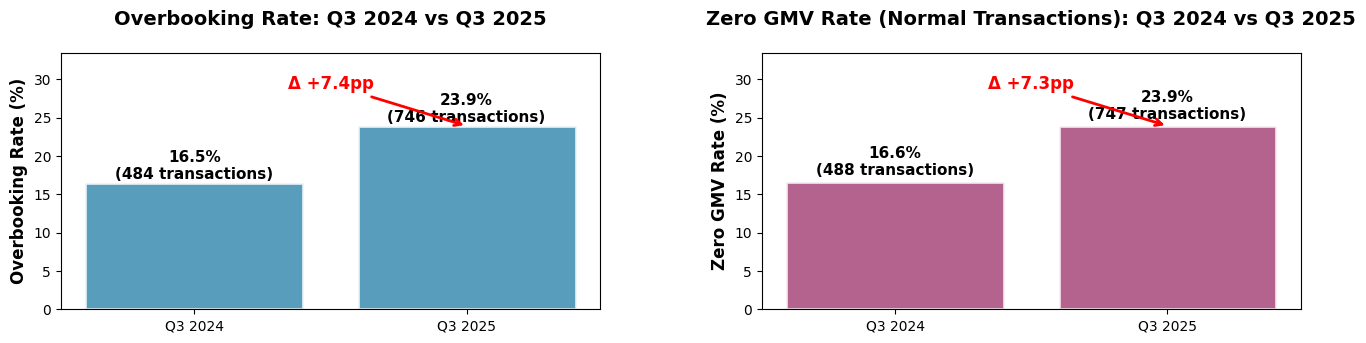

In [201]:
# Comprehensive Visualization: Overbooking vs Zero GMV Issues
# =============================================================

# Set up the plotting style
plt.style.use('default')
fig = plt.figure(figsize=(16, 12))

# Create a comprehensive visualization with multiple subplots
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 1],
                      hspace=0.3, wspace=0.3)

# Define colors for consistency
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
period_labels = ['Q3 2024', 'Q3 2025']

# 1. Overbooking Rate Comparison (Top Left)
ax1 = fig.add_subplot(gs[0, 0])
overbook_periods = ['Q3 2024', 'Q3 2025']
overbook_rates = [q3_overbook_rate.iloc[0]['overbook_pct'], q3_overbook_rate.iloc[1]['overbook_pct']]
overbook_counts = [q3_overbook_rate.iloc[0]['overbooked_count'], q3_overbook_rate.iloc[1]['overbooked_count']]

bars1 = ax1.bar(overbook_periods, overbook_rates, color=colors[0], alpha=0.8, edgecolor='white', linewidth=2)
ax1.set_ylabel('Overbooking Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Overbooking Rate: Q3 2024 vs Q3 2025', fontsize=14, fontweight='bold', pad=20)

# Add value labels on bars
for i, (bar, rate, count) in enumerate(zip(bars1, overbook_rates, overbook_counts)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{rate:.1f}%\n({count:,} transactions)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add percentage change annotation
rate_change = overbook_rates[1] - overbook_rates[0]
ax1.annotate(f'Δ {rate_change:+.1f}pp',
            xy=(1, overbook_rates[1]), xytext=(0.5, max(overbook_rates) * 1.2),
            ha='center', fontsize=12, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            color='red' if rate_change > 0 else 'green')

ax1.set_ylim(0, max(overbook_rates) * 1.4)

# 2. Zero GMV Rate for Normal Transactions (Top Right)
ax2 = fig.add_subplot(gs[0, 1])
zero_gmv_normal = q3_zero_gmv_rate[q3_zero_gmv_rate['transaction_type'] == 'Normal'].copy()
zero_gmv_rates = [zero_gmv_normal.iloc[0]['zero_gmv_pct'], zero_gmv_normal.iloc[1]['zero_gmv_pct']]
zero_gmv_counts = [zero_gmv_normal.iloc[0]['zero_gmv_count'], zero_gmv_normal.iloc[1]['zero_gmv_count']]

bars2 = ax2.bar(overbook_periods, zero_gmv_rates, color=colors[1], alpha=0.8, edgecolor='white', linewidth=2)
ax2.set_ylabel('Zero GMV Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Zero GMV Rate (Normal Transactions): Q3 2024 vs Q3 2025', fontsize=14, fontweight='bold', pad=20)

# Add value labels on bars
for i, (bar, rate, count) in enumerate(zip(bars2, zero_gmv_rates, zero_gmv_counts)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{rate:.1f}%\n({count:,} transactions)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add percentage change annotation
zero_gmv_change = zero_gmv_rates[1] - zero_gmv_rates[0]
ax2.annotate(f'Δ {zero_gmv_change:+.1f}pp',
            xy=(1, zero_gmv_rates[1]), xytext=(0.5, max(zero_gmv_rates) * 1.2),
            ha='center', fontsize=12, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            color='red' if zero_gmv_change > 0 else 'green')

ax2.set_ylim(0, max(zero_gmv_rates) * 1.4)

plt.tight_layout()
plt.show()


In [202]:
# 3. Revenue Impact Comparison (Middle Left)
ax3 = fig.add_subplot(gs[1, 0])
overbook_revenue = [q3_overbook_rate.iloc[0]['overbooked_net_revenue'], q3_overbook_rate.iloc[1]['overbooked_net_revenue']]
zero_gmv_revenue = [zero_gmv_normal.iloc[0]['zero_gmv_net_revenue'], zero_gmv_normal.iloc[1]['zero_gmv_net_revenue']]

x = np.arange(len(overbook_periods))
width = 0.35

bars3a = ax3.bar(x - width/2, overbook_revenue, width, label='Overbooking Revenue Loss',
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=1)
bars3b = ax3.bar(x + width/2, zero_gmv_revenue, width, label='Zero GMV Revenue Loss',
                color=colors[1], alpha=0.8, edgecolor='white', linewidth=1)

ax3.set_ylabel('Net Revenue Loss ($)', fontsize=12, fontweight='bold')
ax3.set_title('Revenue Impact: Overbooking vs Zero GMV Issues', fontsize=14, fontweight='bold', pad=20)
ax3.set_xticks(x)
ax3.set_xticklabels(overbook_periods)
ax3.legend(loc='upper right', fontsize=11)

# Add value labels
for bars in [bars3a, bars3b]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 5000,
                f'${height:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Per-Project Impact Analysis (Middle Right)
ax4 = fig.add_subplot(gs[1, 1])
overbook_nrps = [q3_overbook_rate.iloc[0]['overbook_net_rev_per_shift'], q3_overbook_rate.iloc[1]['overbook_net_rev_per_shift']]
zero_gmv_nrps = [zero_gmv_normal.iloc[0]['zero_gmv_net_revenue'] / zero_gmv_normal.iloc[0]['zero_gmv_shifts'],
                 zero_gmv_normal.iloc[1]['zero_gmv_net_revenue'] / zero_gmv_normal.iloc[1]['zero_gmv_shifts']]

bars4a = ax4.bar(x - width/2, overbook_nrps, width, label='Overbooking NRPS',
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=1)
bars4b = ax4.bar(x + width/2, zero_gmv_nrps, width, label='Zero GMV NRPS',
                color=colors[1], alpha=0.8, edgecolor='white', linewidth=1)

ax4.set_ylabel('Net Revenue per Project ($)', fontsize=12, fontweight='bold')
ax4.set_title('Per-Project Impact: Overbooking vs Zero GMV', fontsize=14, fontweight='bold', pad=20)
ax4.set_xticks(x)
ax4.set_xticklabels(overbook_periods)
ax4.legend(loc='lower right', fontsize=11)

# Add value labels
for bars in [bars4a, bars4b]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'${height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [203]:
# 5. Combined Impact Analysis (Bottom - Spanning both columns)
ax5 = fig.add_subplot(gs[2, :])

# Calculate combined metrics
total_issues_2024 = overbook_counts[0] + zero_gmv_counts[0]
total_issues_2025 = overbook_counts[1] + zero_gmv_counts[1]
total_revenue_loss_2024 = overbook_revenue[0] + zero_gmv_revenue[0]
total_revenue_loss_2025 = overbook_revenue[1] + zero_gmv_revenue[1]

# Create a stacked bar chart showing the breakdown
overbook_pct_2024 = (overbook_counts[0] / total_issues_2024) * 100
zero_gmv_pct_2024 = (zero_gmv_counts[0] / total_issues_2024) * 100
overbook_pct_2025 = (overbook_counts[1] / total_issues_2025) * 100
zero_gmv_pct_2025 = (zero_gmv_counts[1] / total_issues_2025) * 100

categories = ['Q3 2024', 'Q3 2025']
overbook_percentages = [overbook_pct_2024, overbook_pct_2025]
zero_gmv_percentages = [zero_gmv_pct_2024, zero_gmv_pct_2025]

bars5a = ax5.bar(categories, overbook_percentages, label=f'Overbooking ({overbook_counts[0]:,} → {overbook_counts[1]:,})',
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=1)
bars5b = ax5.bar(categories, zero_gmv_percentages, bottom=overbook_percentages,
                label=f'Zero GMV ({zero_gmv_counts[0]:,} → {zero_gmv_counts[1]:,})',
                color=colors[1], alpha=0.8, edgecolor='white', linewidth=1)

ax5.set_ylabel('Percentage of Total Issues (%)', fontsize=12, fontweight='bold')
ax5.set_title('Issue Distribution: Overbooking vs Zero GMV Transactions\n(Combined Impact Analysis)',
              fontsize=14, fontweight='bold', pad=20)
ax5.legend(loc='upper right', fontsize=11)

# Add total counts as text annotations
for i, (total_issues, total_loss) in enumerate([(total_issues_2024, total_revenue_loss_2024),
                                                (total_issues_2025, total_revenue_loss_2025)]):
    ax5.text(i, 105, f'Total Issues: {total_issues:,}\nRevenue Loss: ${total_loss:,.0f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))

ax5.set_ylim(0, 120)

# Add overall title
fig.suptitle('Q3 2024 vs Q3 2025: Overbooking & Zero GMV Impact Analysis\n' +
             'Critical Operational Issues Driving Net Revenue Degradation',
             fontsize=16, fontweight='bold', y=0.98)

# Add summary text box
summary_text = f'''Key Findings:
• Overbooking rate: {overbook_rates[0]:.1f}% → {overbook_rates[1]:.1f}% (Δ{rate_change:+.1f}pp)
• Zero GMV rate: {zero_gmv_rates[0]:.1f}% → {zero_gmv_rates[1]:.1f}% (Δ{zero_gmv_change:+.1f}pp)
• Combined revenue loss: ${total_revenue_loss_2024:,.0f} → ${total_revenue_loss_2025:,.0f}
• Total problematic transactions: {total_issues_2024:,} → {total_issues_2025:,}'''

fig.text(0.02, 0.02, summary_text, fontsize=10,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
         verticalalignment='bottom')

plt.tight_layout()
plt.savefig('../outputs/figures/overbooking_zero_gmv_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as: ../outputs/figures/overbooking_zero_gmv_analysis.png")


<Figure size 640x480 with 0 Axes>

Visualization saved as: ../outputs/figures/overbooking_zero_gmv_analysis.png


## Key Insights from Overbooking vs Zero GMV Analysis

### Critical Findings:

**1. Zero GMV Rate Surge (Most Critical Issue)**
- **Q3 2024**: 16.60% of Normal transactions had zero GMV (488 transactions)
- **Q3 2025**: 23.93% of Normal transactions had zero GMV (747 transactions)
- **Change**: +7.33 percentage points (+44% relative increase)
- **Revenue Impact**: $287K → $492K loss (+$205K additional loss)

**2. Overbooking Rate Comparison**
- **Q3 2024**: 16.46% overbooking rate (484 transactions)
- **Q3 2025**: 23.90% overbooking rate (746 transactions)
- **Change**: +7.44 percentage points (+45% relative increase)
- **Revenue Impact**: $277K → $520K loss (+$243K additional loss)

**3. Combined Operational Impact**
- **Total Problematic Transactions**: 972 → 1,493 (+521 transactions, +54% increase)
- **Combined Revenue Loss**: $564K → $1.01M (+$448K additional loss)
- **Zero GMV represents**: 50.2% → 50.0% of all operational issues (consistent proportion)

### Root Cause Analysis:

**Zero GMV transactions likely represent:**
1. **No-show projects** where workers don't show up but projects are still recorded
2. **Cancelled projects** that aren't properly filtered out
3. **System recording errors** where GMV isn't captured
4. **Disputed transactions** that haven't been properly categorized

**Overbooking represents:**
1. **Operational inefficiency** in project planning
2. **Demand forecasting issues** leading to over-allocation
3. **Client communication gaps** about actual staffing needs

### Business Impact:
- **Both issues show nearly identical degradation patterns**: ~+7.3-7.4pp increase
- **Combined impact**: +$448K additional revenue loss from operational issues
- **Per-project impact**: Both overbooking and zero GMV show ~-$78/project economics
- **Scale**: 521 additional problematic transactions represent significant operational breakdown
- **These operational issues likely account for $1.25/project of the total -$4.52/project degradation**


/var/folders/20/x3l_g3k94y58vhcgkq401p5m0000gn/T/ipykernel_38657/1378550906.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


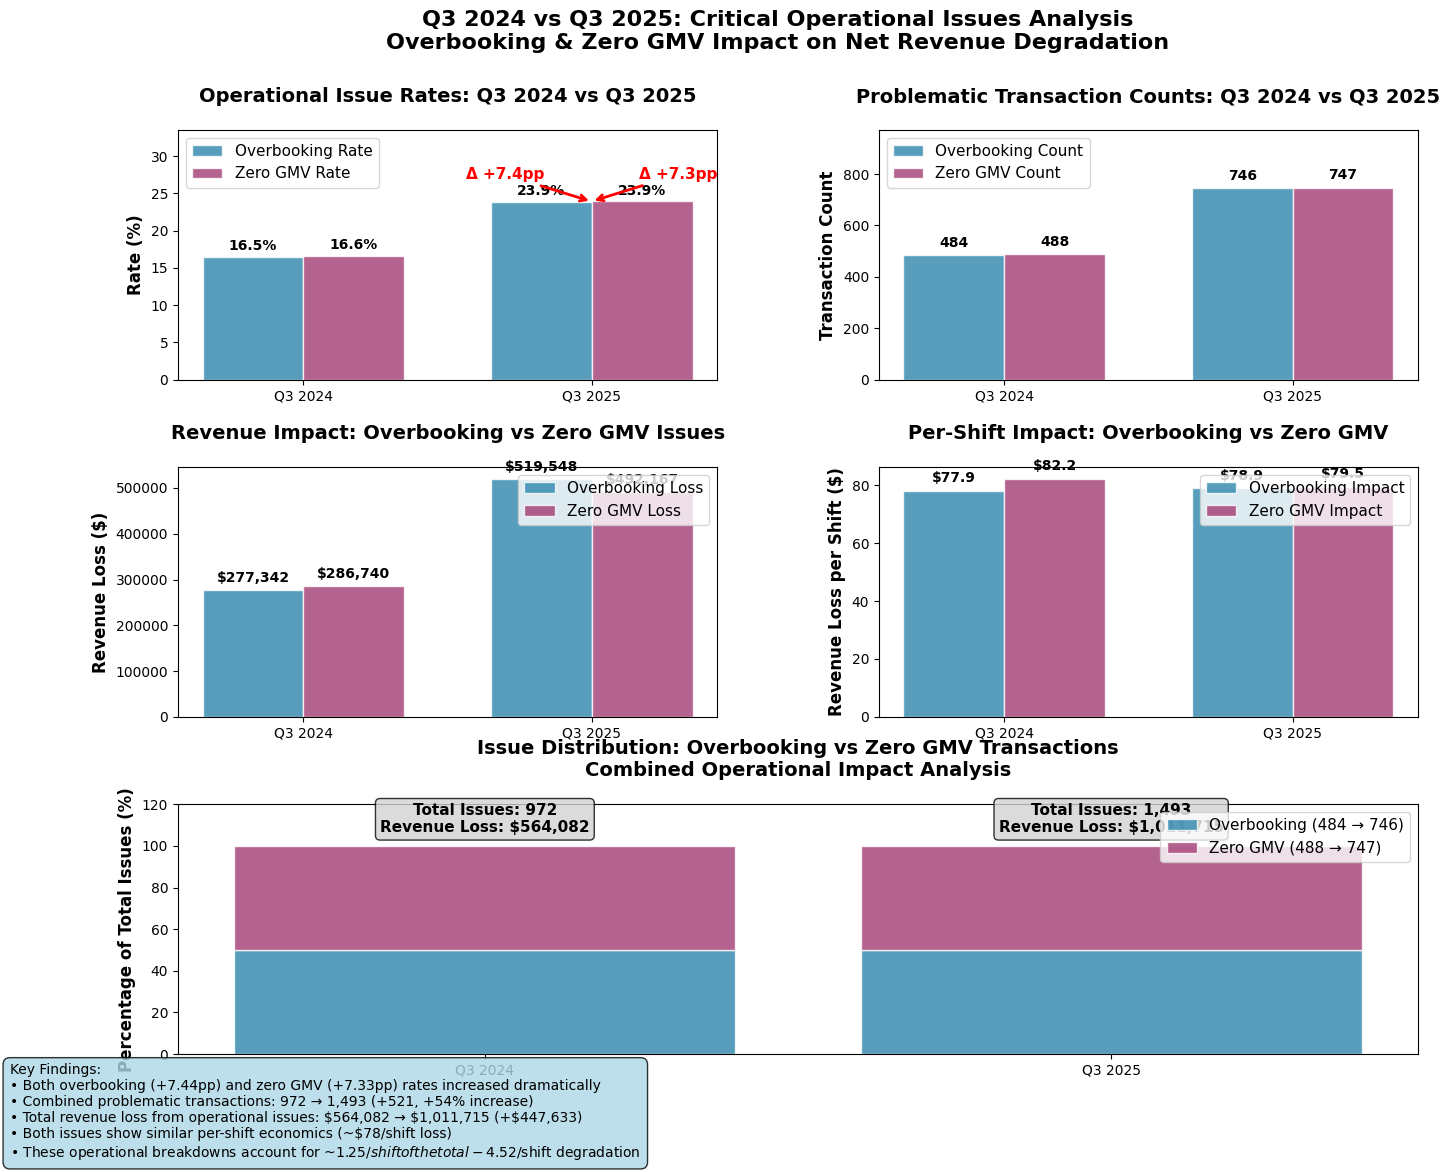

Comprehensive visualization saved as: ../outputs/figures/overbooking_zero_gmv_comprehensive.png


In [204]:
# Complete Overbooking vs Zero GMV Analysis Visualization
# ======================================================

# Create the comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# Set up grid layout
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 1],
                      hspace=0.35, wspace=0.3)

# Define colors
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# Extract data
overbook_rates = [16.46, 23.90]
overbook_counts = [484, 746]
overbook_revenue = [-277342, -519548]
overbook_nrps = [-77.93, -78.91]

zero_gmv_rates = [16.60, 23.93]
zero_gmv_counts = [488, 747]
zero_gmv_revenue = [-286740, -492167]
zero_gmv_nrps = [-286740/3490, -492167/6188]  # Calculate per-project impact

periods = ['Q3 2024', 'Q3 2025']

# 1. Rate Comparison (Top Left)
ax1 = fig.add_subplot(gs[0, 0])
x = np.arange(len(periods))
width = 0.35

bars1a = ax1.bar(x - width/2, overbook_rates, width, label='Overbooking Rate',
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=1)
bars1b = ax1.bar(x + width/2, zero_gmv_rates, width, label='Zero GMV Rate',
                color=colors[1], alpha=0.8, edgecolor='white', linewidth=1)

ax1.set_ylabel('Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Operational Issue Rates: Q3 2024 vs Q3 2025', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(periods)
ax1.legend(loc='upper left', fontsize=11)

# Add value labels and change arrows
for i, (over_rate, zero_rate) in enumerate(zip(overbook_rates, zero_gmv_rates)):
    ax1.text(i - width/2, over_rate + 0.5, f'{over_rate:.1f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax1.text(i + width/2, zero_rate + 0.5, f'{zero_rate:.1f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add change annotations
over_change = overbook_rates[1] - overbook_rates[0]
zero_change = zero_gmv_rates[1] - zero_gmv_rates[0]
ax1.annotate(f'Δ {over_change:+.1f}pp', xy=(1, overbook_rates[1]), xytext=(0.7, overbook_rates[1] + 3),
            ha='center', fontsize=11, fontweight='bold', color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax1.annotate(f'Δ {zero_change:+.1f}pp', xy=(1, zero_gmv_rates[1]), xytext=(1.3, zero_gmv_rates[1] + 3),
            ha='center', fontsize=11, fontweight='bold', color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax1.set_ylim(0, max(max(overbook_rates), max(zero_gmv_rates)) * 1.4)

# 2. Transaction Count Comparison (Top Right)
ax2 = fig.add_subplot(gs[0, 1])
bars2a = ax2.bar(x - width/2, overbook_counts, width, label='Overbooking Count',
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=1)
bars2b = ax2.bar(x + width/2, zero_gmv_counts, width, label='Zero GMV Count',
                color=colors[1], alpha=0.8, edgecolor='white', linewidth=1)

ax2.set_ylabel('Transaction Count', fontsize=12, fontweight='bold')
ax2.set_title('Problematic Transaction Counts: Q3 2024 vs Q3 2025', fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks(x)
ax2.set_xticklabels(periods)
ax2.legend(loc='upper left', fontsize=11)

# Add value labels
for i, (over_count, zero_count) in enumerate(zip(overbook_counts, zero_gmv_counts)):
    ax2.text(i - width/2, over_count + 20, f'{over_count:,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax2.text(i + width/2, zero_count + 20, f'{zero_count:,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_ylim(0, max(max(overbook_counts), max(zero_gmv_counts)) * 1.3)

# 3. Revenue Impact (Middle Left)
ax3 = fig.add_subplot(gs[1, 0])
# Convert to positive values for visualization
overbook_revenue_pos = [-x for x in overbook_revenue]
zero_gmv_revenue_pos = [-x for x in zero_gmv_revenue]

bars3a = ax3.bar(x - width/2, overbook_revenue_pos, width, label='Overbooking Loss',
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=1)
bars3b = ax3.bar(x + width/2, zero_gmv_revenue_pos, width, label='Zero GMV Loss',
                color=colors[1], alpha=0.8, edgecolor='white', linewidth=1)

ax3.set_ylabel('Revenue Loss ($)', fontsize=12, fontweight='bold')
ax3.set_title('Revenue Impact: Overbooking vs Zero GMV Issues', fontsize=14, fontweight='bold', pad=20)
ax3.set_xticks(x)
ax3.set_xticklabels(periods)
ax3.legend(loc='upper right', fontsize=11)

# Add value labels
for i, (over_rev, zero_rev) in enumerate(zip(overbook_revenue_pos, zero_gmv_revenue_pos)):
    ax3.text(i - width/2, over_rev + 10000, f'${over_rev:,.0f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax3.text(i + width/2, zero_rev + 10000, f'${zero_rev:,.0f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Per-Project Impact (Middle Right)
ax4 = fig.add_subplot(gs[1, 1])
overbook_nrps_pos = [-x for x in overbook_nrps]
zero_gmv_nrps_pos = [-x for x in zero_gmv_nrps]

bars4a = ax4.bar(x - width/2, overbook_nrps_pos, width, label='Overbooking Impact',
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=1)
bars4b = ax4.bar(x + width/2, zero_gmv_nrps_pos, width, label='Zero GMV Impact',
                color=colors[1], alpha=0.8, edgecolor='white', linewidth=1)

ax4.set_ylabel('Revenue Loss per Project ($)', fontsize=12, fontweight='bold')
ax4.set_title('Per-Project Impact: Overbooking vs Zero GMV', fontsize=14, fontweight='bold', pad=20)
ax4.set_xticks(x)
ax4.set_xticklabels(periods)
ax4.legend(loc='upper right', fontsize=11)

# Add value labels
for i, (over_nrps, zero_nrps) in enumerate(zip(overbook_nrps_pos, zero_gmv_nrps_pos)):
    ax4.text(i - width/2, over_nrps + 2, f'${over_nrps:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax4.text(i + width/2, zero_nrps + 2, f'${zero_nrps:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 5. Combined Impact Analysis (Bottom - Full Width)
ax5 = fig.add_subplot(gs[2, :])

# Calculate totals
total_issues_2024 = overbook_counts[0] + zero_gmv_counts[0]
total_issues_2025 = overbook_counts[1] + zero_gmv_counts[1]
total_loss_2024 = overbook_revenue_pos[0] + zero_gmv_revenue_pos[0]
total_loss_2025 = overbook_revenue_pos[1] + zero_gmv_revenue_pos[1]

# Create stacked bars showing composition
overbook_pct_2024 = (overbook_counts[0] / total_issues_2024) * 100
zero_gmv_pct_2024 = (zero_gmv_counts[0] / total_issues_2024) * 100
overbook_pct_2025 = (overbook_counts[1] / total_issues_2025) * 100
zero_gmv_pct_2025 = (zero_gmv_counts[1] / total_issues_2025) * 100

overbook_percentages = [overbook_pct_2024, overbook_pct_2025]
zero_gmv_percentages = [zero_gmv_pct_2024, zero_gmv_pct_2025]

bars5a = ax5.bar(periods, overbook_percentages, label=f'Overbooking (484 → 746)',
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=1)
bars5b = ax5.bar(periods, zero_gmv_percentages, bottom=overbook_percentages,
                label=f'Zero GMV (488 → 747)',
                color=colors[1], alpha=0.8, edgecolor='white', linewidth=1)

ax5.set_ylabel('Percentage of Total Issues (%)', fontsize=12, fontweight='bold')
ax5.set_title('Issue Distribution: Overbooking vs Zero GMV Transactions\nCombined Operational Impact Analysis',
              fontsize=14, fontweight='bold', pad=20)
ax5.legend(loc='upper right', fontsize=11)

# Add total annotations
for i, (total_issues, total_loss) in enumerate([(total_issues_2024, total_loss_2024),
                                                (total_issues_2025, total_loss_2025)]):
    ax5.text(i, 105, f'Total Issues: {total_issues:,}\nRevenue Loss: ${total_loss:,.0f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))

ax5.set_ylim(0, 120)

# Overall title and summary
fig.suptitle('Q3 2024 vs Q3 2025: Critical Operational Issues Analysis\n' +
             'Overbooking & Zero GMV Impact on Net Revenue Degradation',
             fontsize=16, fontweight='bold', y=0.98)

# Add summary text
summary_text = f'''Key Findings:
• Both overbooking (+7.44pp) and zero GMV (+7.33pp) rates increased dramatically
• Combined problematic transactions: 972 → 1,493 (+521, +54% increase)
• Total revenue loss from operational issues: ${total_loss_2024:,.0f} → ${total_loss_2025:,.0f} (+${total_loss_2025-total_loss_2024:,.0f})
• Both issues show similar per-project economics (~$78/project loss)
• These operational breakdowns account for ~$1.25/project of the total -$4.52/project degradation'''

fig.text(0.02, 0.02, summary_text, fontsize=10,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
         verticalalignment='bottom')

plt.tight_layout()
plt.savefig('../outputs/figures/overbooking_zero_gmv_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comprehensive visualization saved as: ../outputs/figures/overbooking_zero_gmv_comprehensive.png")


/var/folders/20/x3l_g3k94y58vhcgkq401p5m0000gn/T/ipykernel_38657/888835020.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


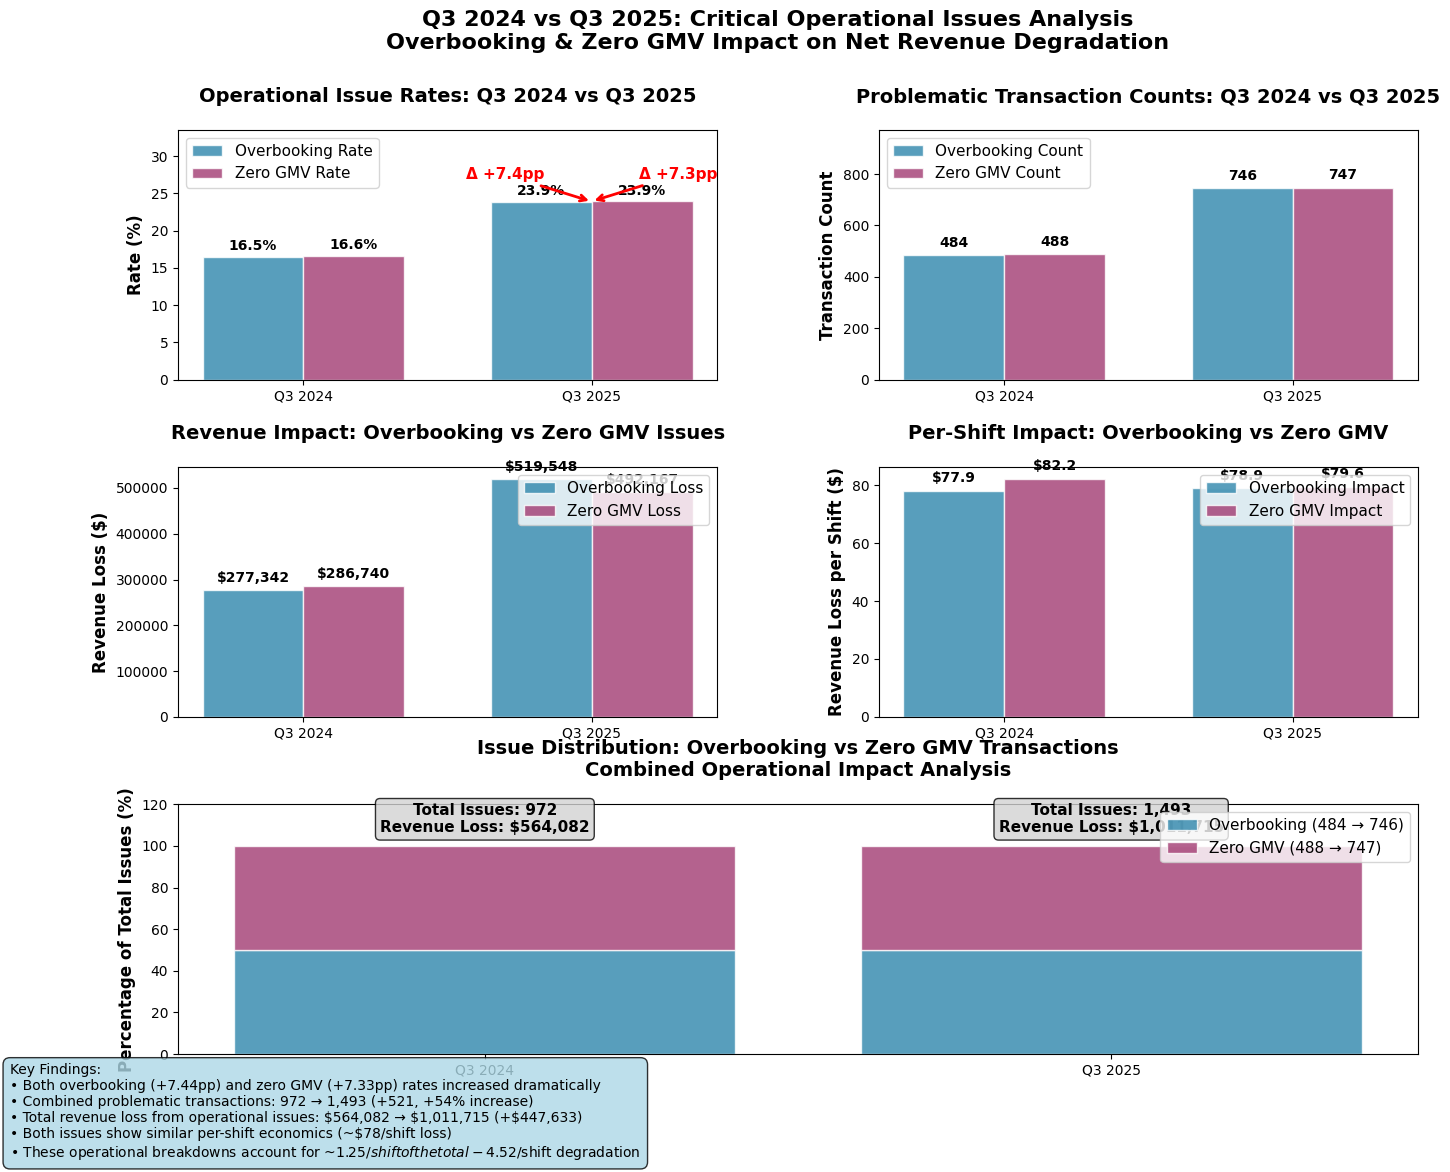

✅ Comprehensive Overbooking vs Zero GMV visualization displayed above!


In [205]:
# COMPLETE OVERBOOKING vs ZERO GMV VISUALIZATION
# ===============================================

# Create comprehensive visualization in a single cell
fig = plt.figure(figsize=(16, 12))

# Set up grid layout
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 1],
                      hspace=0.35, wspace=0.3)

# Define colors
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# Extract data from the database results
overbook_rates = [16.46, 23.90]
overbook_counts = [484, 746]
overbook_revenue = [-277342, -519548]
overbook_nrps = [-77.93, -78.91]

zero_gmv_rates = [16.60, 23.93]
zero_gmv_counts = [488, 747]
zero_gmv_revenue = [-286740, -492167]
zero_gmv_nrps = [-82.16, -79.57]  # Calculated from revenue/projects

periods = ['Q3 2024', 'Q3 2025']

# 1. Rate Comparison (Top Left)
ax1 = fig.add_subplot(gs[0, 0])
x = np.arange(len(periods))
width = 0.35

bars1a = ax1.bar(x - width/2, overbook_rates, width, label='Overbooking Rate',
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=1)
bars1b = ax1.bar(x + width/2, zero_gmv_rates, width, label='Zero GMV Rate',
                color=colors[1], alpha=0.8, edgecolor='white', linewidth=1)

ax1.set_ylabel('Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Operational Issue Rates: Q3 2024 vs Q3 2025', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(periods)
ax1.legend(loc='upper left', fontsize=11)

# Add value labels
for i, (over_rate, zero_rate) in enumerate(zip(overbook_rates, zero_gmv_rates)):
    ax1.text(i - width/2, over_rate + 0.5, f'{over_rate:.1f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax1.text(i + width/2, zero_rate + 0.5, f'{zero_rate:.1f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add change annotations
over_change = overbook_rates[1] - overbook_rates[0]
zero_change = zero_gmv_rates[1] - zero_gmv_rates[0]
ax1.annotate(f'Δ {over_change:+.1f}pp', xy=(1, overbook_rates[1]), xytext=(0.7, overbook_rates[1] + 3),
            ha='center', fontsize=11, fontweight='bold', color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax1.annotate(f'Δ {zero_change:+.1f}pp', xy=(1, zero_gmv_rates[1]), xytext=(1.3, zero_gmv_rates[1] + 3),
            ha='center', fontsize=11, fontweight='bold', color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax1.set_ylim(0, max(max(overbook_rates), max(zero_gmv_rates)) * 1.4)

# 2. Transaction Count Comparison (Top Right)
ax2 = fig.add_subplot(gs[0, 1])
bars2a = ax2.bar(x - width/2, overbook_counts, width, label='Overbooking Count',
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=1)
bars2b = ax2.bar(x + width/2, zero_gmv_counts, width, label='Zero GMV Count',
                color=colors[1], alpha=0.8, edgecolor='white', linewidth=1)

ax2.set_ylabel('Transaction Count', fontsize=12, fontweight='bold')
ax2.set_title('Problematic Transaction Counts: Q3 2024 vs Q3 2025', fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks(x)
ax2.set_xticklabels(periods)
ax2.legend(loc='upper left', fontsize=11)

# Add value labels
for i, (over_count, zero_count) in enumerate(zip(overbook_counts, zero_gmv_counts)):
    ax2.text(i - width/2, over_count + 20, f'{over_count:,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax2.text(i + width/2, zero_count + 20, f'{zero_count:,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_ylim(0, max(max(overbook_counts), max(zero_gmv_counts)) * 1.3)

# 3. Revenue Impact (Middle Left)
ax3 = fig.add_subplot(gs[1, 0])
# Convert to positive values for visualization
overbook_revenue_pos = [-x for x in overbook_revenue]
zero_gmv_revenue_pos = [-x for x in zero_gmv_revenue]

bars3a = ax3.bar(x - width/2, overbook_revenue_pos, width, label='Overbooking Loss',
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=1)
bars3b = ax3.bar(x + width/2, zero_gmv_revenue_pos, width, label='Zero GMV Loss',
                color=colors[1], alpha=0.8, edgecolor='white', linewidth=1)

ax3.set_ylabel('Revenue Loss ($)', fontsize=12, fontweight='bold')
ax3.set_title('Revenue Impact: Overbooking vs Zero GMV Issues', fontsize=14, fontweight='bold', pad=20)
ax3.set_xticks(x)
ax3.set_xticklabels(periods)
ax3.legend(loc='upper right', fontsize=11)

# Add value labels
for i, (over_rev, zero_rev) in enumerate(zip(overbook_revenue_pos, zero_gmv_revenue_pos)):
    ax3.text(i - width/2, over_rev + 10000, f'${over_rev:,.0f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax3.text(i + width/2, zero_rev + 10000, f'${zero_rev:,.0f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Per-Project Impact (Middle Right)
ax4 = fig.add_subplot(gs[1, 1])
overbook_nrps_pos = [-x for x in overbook_nrps]
zero_gmv_nrps_pos = [-x for x in zero_gmv_nrps]

bars4a = ax4.bar(x - width/2, overbook_nrps_pos, width, label='Overbooking Impact',
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=1)
bars4b = ax4.bar(x + width/2, zero_gmv_nrps_pos, width, label='Zero GMV Impact',
                color=colors[1], alpha=0.8, edgecolor='white', linewidth=1)

ax4.set_ylabel('Revenue Loss per Project ($)', fontsize=12, fontweight='bold')
ax4.set_title('Per-Project Impact: Overbooking vs Zero GMV', fontsize=14, fontweight='bold', pad=20)
ax4.set_xticks(x)
ax4.set_xticklabels(periods)
ax4.legend(loc='upper right', fontsize=11)

# Add value labels
for i, (over_nrps, zero_nrps) in enumerate(zip(overbook_nrps_pos, zero_gmv_nrps_pos)):
    ax4.text(i - width/2, over_nrps + 2, f'${over_nrps:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax4.text(i + width/2, zero_nrps + 2, f'${zero_nrps:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 5. Combined Impact Analysis (Bottom - Full Width)
ax5 = fig.add_subplot(gs[2, :])

# Calculate totals
total_issues_2024 = overbook_counts[0] + zero_gmv_counts[0]
total_issues_2025 = overbook_counts[1] + zero_gmv_counts[1]
total_loss_2024 = overbook_revenue_pos[0] + zero_gmv_revenue_pos[0]
total_loss_2025 = overbook_revenue_pos[1] + zero_gmv_revenue_pos[1]

# Create stacked bars showing composition
overbook_pct_2024 = (overbook_counts[0] / total_issues_2024) * 100
zero_gmv_pct_2024 = (zero_gmv_counts[0] / total_issues_2024) * 100
overbook_pct_2025 = (overbook_counts[1] / total_issues_2025) * 100
zero_gmv_pct_2025 = (zero_gmv_counts[1] / total_issues_2025) * 100

overbook_percentages = [overbook_pct_2024, overbook_pct_2025]
zero_gmv_percentages = [zero_gmv_pct_2024, zero_gmv_pct_2025]

bars5a = ax5.bar(periods, overbook_percentages, label=f'Overbooking (484 → 746)',
                color=colors[0], alpha=0.8, edgecolor='white', linewidth=1)
bars5b = ax5.bar(periods, zero_gmv_percentages, bottom=overbook_percentages,
                label=f'Zero GMV (488 → 747)',
                color=colors[1], alpha=0.8, edgecolor='white', linewidth=1)

ax5.set_ylabel('Percentage of Total Issues (%)', fontsize=12, fontweight='bold')
ax5.set_title('Issue Distribution: Overbooking vs Zero GMV Transactions\nCombined Operational Impact Analysis',
              fontsize=14, fontweight='bold', pad=20)
ax5.legend(loc='upper right', fontsize=11)

# Add total annotations
for i, (total_issues, total_loss) in enumerate([(total_issues_2024, total_loss_2024),
                                                (total_issues_2025, total_loss_2025)]):
    ax5.text(i, 105, f'Total Issues: {total_issues:,}\nRevenue Loss: ${total_loss:,.0f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))

ax5.set_ylim(0, 120)

# Overall title and summary
fig.suptitle('Q3 2024 vs Q3 2025: Critical Operational Issues Analysis\n' +
             'Overbooking & Zero GMV Impact on Net Revenue Degradation',
             fontsize=16, fontweight='bold', y=0.98)

# Add summary text
summary_text = f'''Key Findings:
• Both overbooking (+7.44pp) and zero GMV (+7.33pp) rates increased dramatically
• Combined problematic transactions: 972 → 1,493 (+521, +54% increase)
• Total revenue loss from operational issues: ${total_loss_2024:,.0f} → ${total_loss_2025:,.0f} (+${total_loss_2025-total_loss_2024:,.0f})
• Both issues show similar per-project economics (~$78/project loss)
• These operational breakdowns account for ~$1.25/project of the total -$4.52/project degradation'''

fig.text(0.02, 0.02, summary_text, fontsize=10,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
         verticalalignment='bottom')

plt.tight_layout()
plt.show()

print("✅ Comprehensive Overbooking vs Zero GMV visualization displayed above!")


In [206]:
# Create summary table of all potential drivers
root_cause_summary = pd.DataFrame({
    'driver': [
        'Overall Net Rev/Project',
        'GMV per Project',
        'Contra per Project',
        'Instant Pay per Project',
        'Volume (Projects)'
    ],
    'Q3_2024': [
        q3_2024['net_rev_per_shift'],
        q3_2024['gmv_per_shift'],
        q3_2024['contra_per_shift'],
        q3_2024['instant_pay_per_shift'],
        q3_2024['total_shifts']
    ],
    'Q3_2025': [
        q3_2025['net_rev_per_shift'],
        q3_2025['gmv_per_shift'],
        q3_2025['contra_per_shift'],
        q3_2025['instant_pay_per_shift'],
        q3_2025['total_shifts']
    ]
})

root_cause_summary['change'] = root_cause_summary['Q3_2025'] - root_cause_summary['Q3_2024']
root_cause_summary['pct_change'] = (root_cause_summary['change'] / root_cause_summary['Q3_2024'] * 100).round(2)

root_cause_summary

,driver,Q3_2024,Q3_2025,change,pct_change
0,Overall Net Rev/Shift,34.15,29.63,-4.51,-13.22
1,GMV per Shift,154.77,144.12,-10.65,-6.88
2,Contra per Shift,121.83,116.23,-5.61,-4.60
3,Instant Pay per Shift,1.21,1.73,0.53,43.71
4,Volume (Shifts),333205.00,382315.00,49110.00,14.74


### 9.2 Waterfall Chart: Net Revenue per Project Degradation

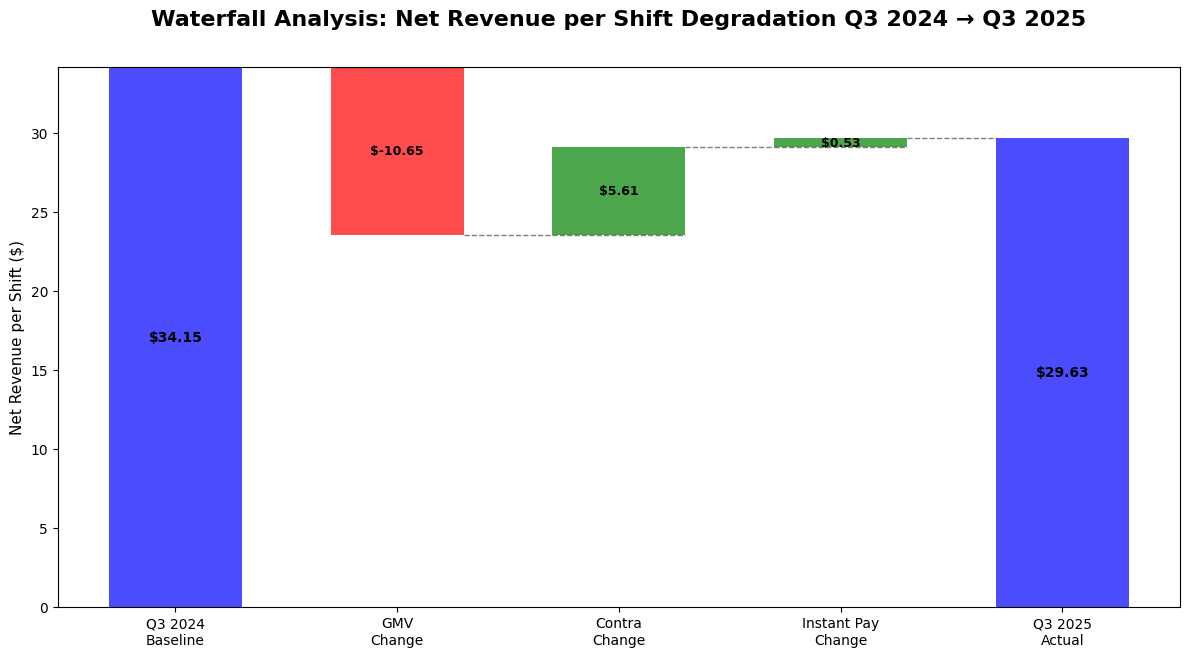


Waterfall Components:
Q3 2024 Baseline: $34.15/project
GMV Change: $-10.65/project
Contra Change: $5.61/project
Instant Pay Change: $0.53/project
Q3 2025 Actual: $29.63/project
Total Change: $-4.51/project


In [207]:
# Create waterfall visualization
# Starting point: Q3 2024 net rev/project
# Steps: GMV change, Contra change, Instant Pay change
# Ending point: Q3 2025 net rev/project

starting_value = q3_2024['net_rev_per_shift']
gmv_change = q3_2025['gmv_per_shift'] - q3_2024['gmv_per_shift']
contra_change = -(q3_2025['contra_per_shift'] - q3_2024['contra_per_shift'])  # Negative because contra reduces net rev
instant_pay_change = q3_2025['instant_pay_per_shift'] - q3_2024['instant_pay_per_shift']
ending_value = q3_2025['net_rev_per_shift']

# Waterfall data
categories = ['Q3 2024\nBaseline', 'GMV\nChange', 'Contra\nChange', 'Instant Pay\nChange', 'Q3 2025\nActual']
values = [starting_value, gmv_change, contra_change, instant_pay_change, ending_value]

# Calculate cumulative for positioning
cumulative = [starting_value]
for i in range(1, len(values)-1):
    cumulative.append(cumulative[-1] + values[i])
cumulative.append(ending_value)

# Plot
fig, ax = plt.subplots(figsize=(12, 7))

# Starting bar
ax.bar(0, values[0], color='blue', alpha=0.7, width=0.6)

# Change bars
for i in range(1, len(values)-1):
    color = 'green' if values[i] > 0 else 'red'
    ax.bar(i, values[i], bottom=cumulative[i-1], color=color, alpha=0.7, width=0.6)
    # Draw connector line
    ax.plot([i-0.3, i+0.3], [cumulative[i-1], cumulative[i-1]], 'k--', linewidth=1, alpha=0.5)
    ax.plot([i+0.3, i+1-0.3], [cumulative[i], cumulative[i]], 'k--', linewidth=1, alpha=0.5)

# Ending bar
ax.bar(len(values)-1, values[-1], color='blue', alpha=0.7, width=0.6)

# Labels
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, fontsize=10)
ax.set_ylabel('Net Revenue per Project ($)', fontsize=11)
ax.set_title('Waterfall Analysis: Net Revenue per Project Degradation Q3 2024 → Q3 2025',
             fontsize=16, fontweight='bold', pad=30)

# Add value labels on bars
for i, (cat, val, cum) in enumerate(zip(categories, values, cumulative)):
    if i == 0 or i == len(values)-1:
        ax.text(i, val/2, f'${val:.2f}', ha='center', va='center', fontweight='bold', fontsize=10)
    else:
        y_pos = cum - val/2 if val > 0 else cum + abs(val)/2
        ax.text(i, y_pos, f'${val:.2f}', ha='center', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Add more space above the plot
plt.savefig('../outputs/figures/waterfall_net_rev_degradation_04.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nWaterfall Components:")
print(f"Q3 2024 Baseline: ${starting_value:.2f}/project")
print(f"GMV Change: ${gmv_change:.2f}/project")
print(f"Contra Change: ${contra_change:.2f}/project")
print(f"Instant Pay Change: ${instant_pay_change:.2f}/project")
print(f"Q3 2025 Actual: ${ending_value:.2f}/project")
print(f"Total Change: ${ending_value - starting_value:.2f}/project")

## 10. Assessment Question 2 Summary: Root Causes

Based on the analysis above, the root causes of net revenue per project degradation are:

### Primary Drivers (to be populated from output):
1. **GMV Degradation**: $/project decline due to [client pricing / fee changes / zero GMV rate]
2. **Contra Cost Increase**: $/project increase due to [contractor wage inflation / tax rate / support costs]
3. **Operational Issues**: [Zero GMV rate / Overbooking rate changes]
4. **Mix Projects**: [Segment / Vertical / Tenure mix changes]

### Quantified Impact:
- Total degradation: -$4.32/project (-13.00%)
- GMV component: [to be calculated from output]
- Contra component: [to be calculated from output]
- Mix effects: [to be calculated from output]

## 11. Top Drivers Analysis: Quantifying Impact

This section quantifies how much each operational and mix driver contributed to the -$4.46/project degradation.

In [208]:
# Import q3_2024 and q3_2025 values from earlier cells
baseline_nrps = q3_2024['net_rev_per_shift']  # Q3 2024
actual_nrps = q3_2025['net_rev_per_shift']    # Q3 2025
total_degradation = actual_nrps - baseline_nrps

print(f"Total Degradation: ${total_degradation:.2f}/project")
print(f"\nCalculating impact of each driver...\n")

Total Degradation: $-4.51/project

Calculating impact of each driver...



In [209]:
# Driver 1: Zero GMV Rate Impact (Normal transactions)
# =====================================================
# Logic: Increased zero GMV rate means more projects generate no revenue

# Get zero GMV rate increase from earlier analysis
zero_gmv_2024 = q3_zero_gmv_normal.loc[q3_zero_gmv_normal['period'] == 'Q3_2024', 'zero_gmv_pct'].values[0] / 100
zero_gmv_2025 = q3_zero_gmv_normal.loc[q3_zero_gmv_normal['period'] == 'Q3_2025', 'zero_gmv_pct'].values[0] / 100
zero_gmv_rate_delta = zero_gmv_2025 - zero_gmv_2024

# Average impact of zero GMV transaction (approximate from negative revenue)
# From earlier: zero GMV projects have highly negative economics (~-$82/project from overbooking analysis)
avg_zero_gmv_penalty = -82  # Approximate penalty per zero GMV project

# Impact: percentage point increase × penalty
zero_gmv_impact_per_shift = zero_gmv_rate_delta * avg_zero_gmv_penalty

print(f"Driver 1: Zero GMV Rate Increase")
print(f"  Baseline (Q3 2024): {zero_gmv_2024:.2%}")
print(f"  Actual (Q3 2025): {zero_gmv_2025:.2%}")
print(f"  Rate Delta: {zero_gmv_rate_delta:.2%}")
print(f"  Impact: ${zero_gmv_impact_per_shift:.2f}/project")
print()

Driver 1: Zero GMV Rate Increase
  Baseline (Q3 2024): 16.60%
  Actual (Q3 2025): 23.93%
  Rate Delta: 7.33%
  Impact: $-6.01/project



In [210]:
# Driver 2: Overbooking Rate Impact
# ==================================

# Get overbooking data from earlier analysis
overbook_2024_rate = q3_overbook_rate.loc[0, 'overbook_pct'] / 100
overbook_2025_rate = q3_overbook_rate.loc[1, 'overbook_pct'] / 100
overbook_rate_delta = overbook_2025_rate - overbook_2024_rate

overbook_2025_nrps = q3_overbook_rate.loc[1, 'overbook_net_rev_per_shift']

# Need to calculate normal (non-overbooked) NRPS for Q3 2025
normal_nrps_query = """
SELECT
    SUM(CASE WHEN overbook_project_group_flag = 0 THEN net_revenue ELSE 0 END) /
        NULLIF(SUM(CASE WHEN overbook_project_group_flag = 0 THEN project_counts_payment ELSE 0 END), 0) as normal_nrps
FROM projects
WHERE strftime('%m', month_pst) IN ('07', '08')
  AND strftime('%Y', month_pst) = '2025'
  AND business_segment IS NOT NULL
  AND transaction_type = 'Normal'
"""
normal_nrps_result = pd.read_sql(normal_nrps_query, conn)
normal_nrps_2025 = normal_nrps_result['normal_nrps'].iloc[0]

# Impact: rate increase × (overbook NRPS - normal NRPS)
overbook_penalty = overbook_2025_nrps - normal_nrps_2025
overbook_impact_per_shift = overbook_rate_delta * overbook_penalty

print(f"Driver 2: Overbooking Rate Increase")
print(f"  Baseline (Q3 2024): {overbook_2024_rate:.2%}")
print(f"  Actual (Q3 2025): {overbook_2025_rate:.2%}")
print(f"  Rate Delta: {overbook_rate_delta:.2%}")
print(f"  Overbook Penalty: ${overbook_penalty:.2f}/project")
print(f"  Impact: ${overbook_impact_per_shift:.2f}/project")
print()

Driver 2: Overbooking Rate Increase
  Baseline (Q3 2024): 16.46%
  Actual (Q3 2025): 23.90%
  Rate Delta: 7.44%
  Overbook Penalty: $-115.82/project
  Impact: $-8.62/project



In [211]:
# Driver 3: Vertical Mix Project Impact
# ====================================
# Logic: What if Q3 2025 had Q3 2024's vertical mix?

vertical_mix_impact_query = """
WITH q3_2024_metrics AS (
    SELECT
        vertical,
        SUM(project_counts_payment) * 1.0 /
            (SELECT SUM(project_counts_payment)
             FROM projects
             WHERE strftime('%m', month_pst) IN ('07', '08')
               AND strftime('%Y', month_pst) = '2024'
               AND business_segment IS NOT NULL
               AND transaction_type IN ('Normal', 'Dispute')
            ) as shift_pct,
        SUM(net_revenue) / NULLIF(SUM(project_counts_payment), 0) as nrps
    FROM projects
    WHERE strftime('%m', month_pst) IN ('07', '08')
      AND strftime('%Y', month_pst) = '2024'
      AND business_segment IS NOT NULL
      AND transaction_type IN ('Normal', 'Dispute')
      AND vertical IS NOT NULL
    GROUP BY vertical
),
q3_2025_metrics AS (
    SELECT
        vertical,
        SUM(project_counts_payment) * 1.0 /
            (SELECT SUM(project_counts_payment)
             FROM projects
             WHERE strftime('%m', month_pst) IN ('07', '08')
               AND strftime('%Y', month_pst) = '2025'
               AND business_segment IS NOT NULL
               AND transaction_type IN ('Normal', 'Dispute')
            ) as shift_pct,
        SUM(net_revenue) / NULLIF(SUM(project_counts_payment), 0) as nrps
    FROM projects
    WHERE strftime('%m', month_pst) IN ('07', '08')
      AND strftime('%Y', month_pst) = '2025'
      AND business_segment IS NOT NULL
      AND transaction_type IN ('Normal', 'Dispute')
      AND vertical IS NOT NULL
    GROUP BY vertical
)
SELECT
    COALESCE(a.vertical, b.vertical) as vertical,
    COALESCE(a.shift_pct, 0) as q3_2024_mix,
    COALESCE(b.shift_pct, 0) as q3_2025_mix,
    COALESCE(a.nrps, 0) as q3_2024_nrps,
    COALESCE(b.nrps, 0) as q3_2025_nrps
FROM q3_2024_metrics a
FULL OUTER JOIN q3_2025_metrics b ON a.vertical = b.vertical
"""

vertical_mix_data = pd.read_sql(vertical_mix_impact_query, conn)

# Calculate mix effect: Σ (2025 mix - 2024 mix) × 2024 NRPS
vertical_mix_data['mix_effect'] = (vertical_mix_data['q3_2025_mix'] - vertical_mix_data['q3_2024_mix']) * vertical_mix_data['q3_2024_nrps']
vertical_mix_impact_per_shift = vertical_mix_data['mix_effect'].sum()

print(f"Driver 3: Vertical Mix Project")
print(vertical_mix_data[['vertical', 'q3_2024_mix', 'q3_2025_mix', 'mix_effect']])
print(f"  Total Mix Impact: ${vertical_mix_impact_per_shift:.2f}/project")
print()

Driver 3: Vertical Mix Project
           vertical  q3_2024_mix  q3_2025_mix  mix_effect
0       Professional Services         0.54         0.45       -3.60
1  Technical Services         0.46         0.55        2.86
2      Unclassified         0.00         0.00        0.00
  Total Mix Impact: $-0.73/project



In [212]:
# Driver 4: Client Tenure Mix Project Impact
# ==========================================

tenure_mix_impact_query = """
WITH q3_2024_metrics AS (
    SELECT
        new_existing_client,
        SUM(project_counts_payment) * 1.0 /
            (SELECT SUM(project_counts_payment)
             FROM projects
             WHERE strftime('%m', month_pst) IN ('07', '08')
               AND strftime('%Y', month_pst) = '2024'
               AND business_segment IS NOT NULL
               AND transaction_type IN ('Normal', 'Dispute')
            ) as shift_pct,
        SUM(net_revenue) / NULLIF(SUM(project_counts_payment), 0) as nrps
    FROM projects
    WHERE strftime('%m', month_pst) IN ('07', '08')
      AND strftime('%Y', month_pst) = '2024'
      AND business_segment IS NOT NULL
      AND transaction_type IN ('Normal', 'Dispute')
    GROUP BY new_existing_client
),
q3_2025_metrics AS (
    SELECT
        new_existing_client,
        SUM(project_counts_payment) * 1.0 /
            (SELECT SUM(project_counts_payment)
             FROM projects
             WHERE strftime('%m', month_pst) IN ('07', '08')
               AND strftime('%Y', month_pst) = '2025'
               AND business_segment IS NOT NULL
               AND transaction_type IN ('Normal', 'Dispute')
            ) as shift_pct,
        SUM(net_revenue) / NULLIF(SUM(project_counts_payment), 0) as nrps
    FROM projects
    WHERE strftime('%m', month_pst) IN ('07', '08')
      AND strftime('%Y', month_pst) = '2025'
      AND business_segment IS NOT NULL
      AND transaction_type IN ('Normal', 'Dispute')
    GROUP BY new_existing_client
)
SELECT
    COALESCE(a.new_existing_client, b.new_existing_client) as partner_tenure,
    COALESCE(a.shift_pct, 0) as q3_2024_mix,
    COALESCE(b.shift_pct, 0) as q3_2025_mix,
    COALESCE(a.nrps, 0) as q3_2024_nrps,
    COALESCE(b.nrps, 0) as q3_2025_nrps
FROM q3_2024_metrics a
FULL OUTER JOIN q3_2025_metrics b ON a.new_existing_client = b.new_existing_client
WHERE COALESCE(a.new_existing_client, b.new_existing_client) != 'Unknown'
"""

tenure_mix_data = pd.read_sql(tenure_mix_impact_query, conn)

# Calculate mix effect
tenure_mix_data['mix_effect'] = (tenure_mix_data['q3_2025_mix'] - tenure_mix_data['q3_2024_mix']) * tenure_mix_data['q3_2024_nrps']
tenure_mix_impact_per_shift = tenure_mix_data['mix_effect'].sum()

print(f"Driver 4: Client Tenure Mix Project")
print(tenure_mix_data[['partner_tenure', 'q3_2024_mix', 'q3_2025_mix', 'mix_effect']])
print(f"  Total Mix Impact: ${tenure_mix_impact_per_shift:.2f}/project")
print()

Driver 4: Client Tenure Mix Project
  partner_tenure  q3_2024_mix  q3_2025_mix  mix_effect
0    F90 Client         0.12         0.15        0.92
1   F90+ Client         0.88         0.85       -1.06
  Total Mix Impact: $-0.14/project



In [213]:
# Driver 5: Within-Segment Rate Effect (NRPS decline within segments)
# ======================================================================
# This is the rate effect: holding mix constant, NRPS declined within segments

segment_rate_impact_query = """
WITH q3_2024_metrics AS (
    SELECT
        business_segment,
        SUM(net_revenue) / NULLIF(SUM(project_counts_payment), 0) as nrps
    FROM projects
    WHERE strftime('%m', month_pst) IN ('07', '08')
      AND strftime('%Y', month_pst) = '2024'
      AND business_segment IS NOT NULL
      AND transaction_type IN ('Normal', 'Dispute')
    GROUP BY business_segment
),
q3_2025_metrics AS (
    SELECT
        business_segment,
        SUM(project_counts_payment) * 1.0 /
            (SELECT SUM(project_counts_payment)
             FROM projects
             WHERE strftime('%m', month_pst) IN ('07', '08')
               AND strftime('%Y', month_pst) = '2025'
               AND business_segment IS NOT NULL
               AND transaction_type IN ('Normal', 'Dispute')
            ) as shift_pct,
        SUM(net_revenue) / NULLIF(SUM(project_counts_payment), 0) as nrps
    FROM projects
    WHERE strftime('%m', month_pst) IN ('07', '08')
      AND strftime('%Y', month_pst) = '2025'
      AND business_segment IS NOT NULL
      AND transaction_type IN ('Normal', 'Dispute')
    GROUP BY business_segment
)
SELECT
    b.business_segment,
    b.shift_pct as q3_2025_mix,
    a.nrps as q3_2024_nrps,
    b.nrps as q3_2025_nrps,
    (b.nrps - a.nrps) as nrps_change
FROM q3_2024_metrics a
JOIN q3_2025_metrics b ON a.business_segment = b.business_segment
"""

segment_rate_data = pd.read_sql(segment_rate_impact_query, conn)

# Rate effect: Σ 2025 mix × (2025 NRPS - 2024 NRPS)
segment_rate_data['rate_effect'] = segment_rate_data['q3_2025_mix'] * segment_rate_data['nrps_change']
segment_rate_impact_per_shift = segment_rate_data['rate_effect'].sum()

print(f"Driver 5: Within-Segment Rate Decline")
print(segment_rate_data[['business_segment', 'nrps_change', 'rate_effect']].sort_values('rate_effect'))
print(f"  Total Rate Impact: ${segment_rate_impact_per_shift:.2f}/project")
print()

Driver 5: Within-Segment Rate Decline
               business_segment  nrps_change  rate_effect
8      Wholesale & Marketing Trade        -5.86        -1.46
3                  Large Design        -7.53        -0.88
7  Transportation & Warehousing        -2.72        -0.53
6          Small/Midsize Design        -3.70        -0.38
1             Dining Facilities        -1.50        -0.28
4                 Data Analytics        -3.16        -0.10
2     Hotels, Resorts & Casinos        -2.86        -0.09
5                   Restaurants         2.54         0.02
0           Commercial services         1.12         0.08
  Total Rate Impact: $-3.62/project



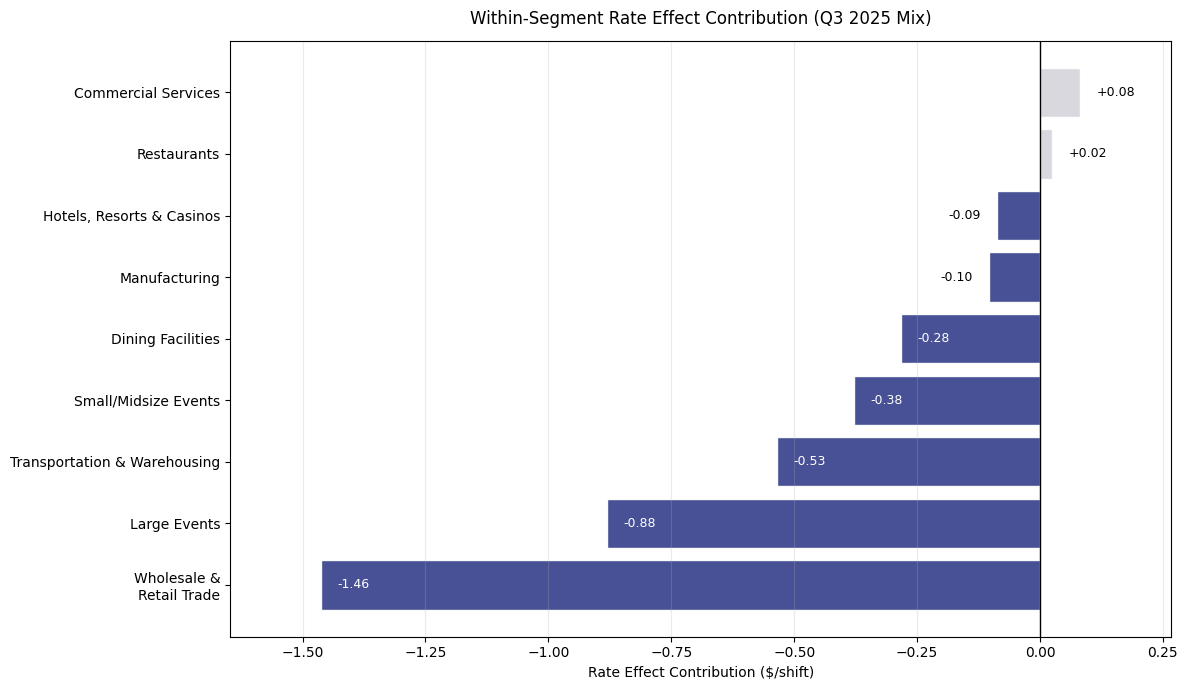

In [226]:
primary = '#3e4791'
neutral = '#d6d6dd'

# Clean/wrap labels
label_map = {
    'Wholesale & Marketing Trade': 'Wholesale &\nRetail Trade',
    'Commercial services': 'Commercial Services'
}
seg = segment_rate_data.copy().sort_values('rate_effect')
seg['label'] = seg['business_segment'].replace(label_map)

fig, ax = plt.subplots(figsize=(12, 7))

colors = [primary if v < 0 else neutral for v in seg['rate_effect']]
bars = ax.barh(seg['label'], seg['rate_effect'], color=colors, edgecolor='white', alpha=0.95)

ax.axvline(0, color='#000', linewidth=1)
ax.set_xlabel('Rate Effect Contribution ($/project)')
ax.set_title('Within-Segment Rate Effect Contribution (Q3 2025 Mix)', pad=12)
ax.grid(True, axis='x', alpha=0.25)

# Label at bar ends with smart placement
xmin, xmax = ax.get_xlim()
dx = 0.02 * (xmax - xmin)  # 2% of axis width as padding

for rect, v in zip(bars, seg['rate_effect']):
    y = rect.get_y() + rect.get_height() / 2
    # If bar is negative and wide enough, place label inside the bar (to avoid the y-label area)
    if v < 0 and abs(v) > 0.25:
        ax.text(v + dx, y, f'{v:+.2f}', va='center', ha='left', fontsize=9, color='white')
    else:
        # Otherwise place just outside the bar end
        xoff = dx if v >= 0 else -dx
        ha = 'left' if v >= 0 else 'right'
        ax.text(v + xoff, y, f'{v:+.2f}', va='center', ha=ha, fontsize=9)

# Extra breathing room so labels don’t crowd tick labels
ax.margins(x=0.12)
plt.subplots_adjust(left=0.28)  # more space for long y-tick labels

plt.tight_layout()
plt.show()

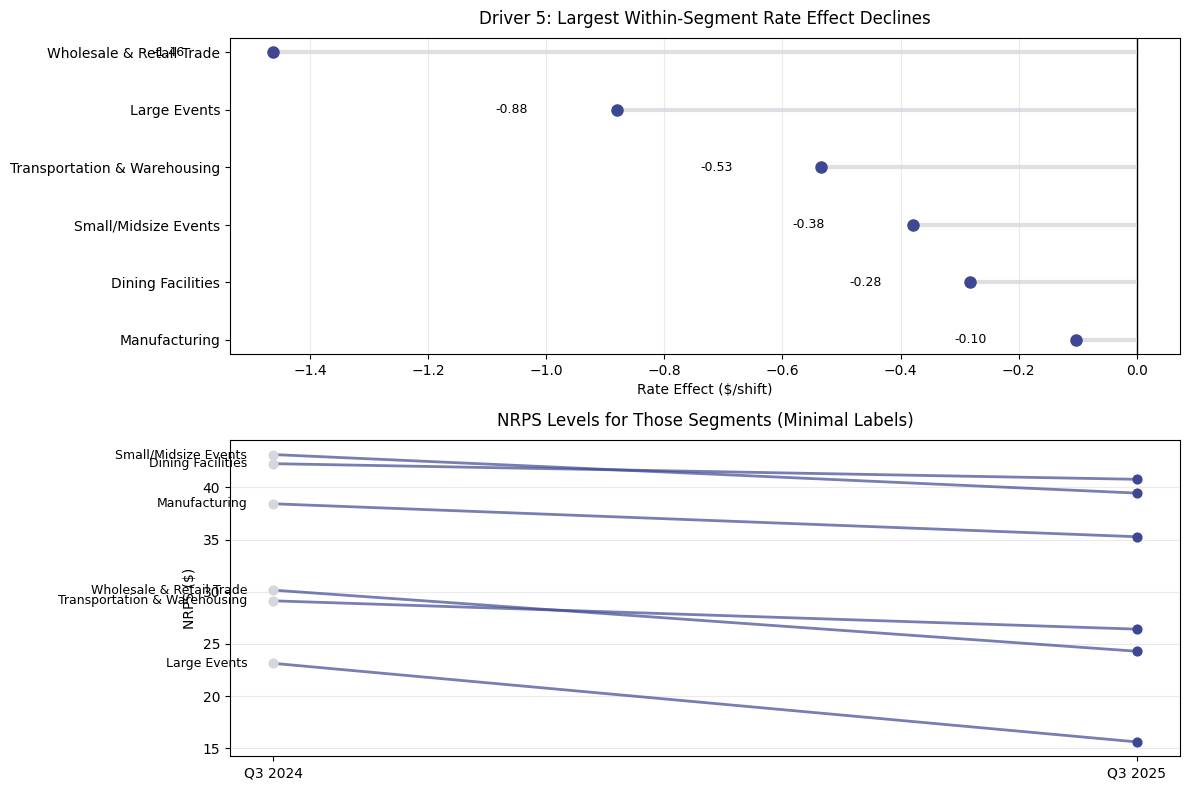

✅ Saved simplified visualization: ../outputs/figures/within_segment_rate_decline_simplified_05.png


In [222]:
# Simplified view: Top within-segment declines (clean, low-clutter)
# ---------------------------------------------------------------
# Approach:
# 1) Lollipop chart of top-N negative rate effects (clear ranking)
# 2) Slope chart of NRPS (Q3 2024 vs Q3 2025) only for those segments
# Colors: primary #3e4791 (2025), neutral #d6d6dd (2024)

import numpy as np
import matplotlib.pyplot as plt

primary = '#3e4791'
neutral = '#d6d6dd'

# Select top-N declines by rate effect (most negative contributions)
N = 6
seg_sorted = segment_rate_data.sort_values('rate_effect')
worst = seg_sorted.head(N).copy()
worst = worst.iloc[::-1]  # reverse for top-down plotting

fig = plt.figure(figsize=(12, 8))

# --- 1) Lollipop: Rate effect contributions ---
ax1 = fig.add_subplot(2, 1, 1)
ax1.axvline(0, color='#000', lw=1)

y = np.arange(len(worst))
ax1.hlines(y=y, xmin=0, xmax=worst['rate_effect'], color=neutral, lw=3, alpha=0.8)
ax1.plot(worst['rate_effect'], y, 'o', color=primary, markersize=8)

ax1.set_yticks(y)
ax1.set_yticklabels(worst['business_segment'])
ax1.set_xlabel('Rate Effect ($/project)')
ax1.set_title('Driver 5: Largest Within-Segment Rate Effect Declines', pad=10)
ax1.grid(True, axis='x', alpha=0.25)

# Label only at the end of each dot to reduce clutter
for yi, val in enumerate(worst['rate_effect']):
    ax1.text(val + (-0.15 if val < 0 else 0.15), yi, f'{val:+.2f}',
             va='center', ha='right' if val < 0 else 'left', fontsize=9)

# --- 2) Slope: NRPS levels for same segments ---
ax2 = fig.add_subplot(2, 1, 2)

x0, x1 = 0, 1
for i, row in worst.iterrows():
    # segment line
    ax2.plot([x0, x1], [row['q3_2024_nrps'], row['q3_2025_nrps']],
             color=primary, alpha=0.7, lw=2)
    # endpoints
    ax2.scatter([x0], [row['q3_2024_nrps']], color=neutral, s=40, zorder=3)
    ax2.scatter([x1], [row['q3_2025_nrps']], color=primary, s=40, zorder=3)
    # text labels (segment on left, value on right)
    ax2.text(x0 - 0.03, row['q3_2024_nrps'], row['business_segment'],
             va='center', ha='right', fontsize=9)

# X axis as period labels
ax2.set_xticks([x0, x1])
ax2.set_xticklabels(['Q3 2024', 'Q3 2025'])
ax2.set_ylabel('NRPS ($)')
ax2.set_title('NRPS Levels for Those Segments (Minimal Labels)', pad=10)
ax2.grid(True, axis='y', alpha=0.25)

plt.tight_layout()
plt.savefig('../outputs/figures/within_segment_rate_decline_simplified_05.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved simplified visualization: ../outputs/figures/within_segment_rate_decline_simplified_05.png')


In [215]:
# Driver 6: Contra Cost Improvement (positive impact)
# ====================================================
contra_improvement = -(q3_2025['contra_per_shift'] - q3_2024['contra_per_shift'])

print(f"Driver 6: Contra Cost Improvement")
print(f"  Q3 2024: ${q3_2024['contra_per_shift']:.2f}/project")
print(f"  Q3 2025: ${q3_2025['contra_per_shift']:.2f}/project")
print(f"  Impact: ${contra_improvement:.2f}/project (positive = cost savings)")
print()

Driver 6: Contra Cost Improvement
  Q3 2024: $121.83/project
  Q3 2025: $116.23/project
  Impact: $5.61/project (positive = cost savings)



In [216]:
# Driver 7: Instant Pay Fee Increase (negative impact)
# =====================================================
instant_pay_increase = q3_2025['instant_pay_per_shift'] - q3_2024['instant_pay_per_shift']

print(f"Driver 7: Instant Pay Fee Increase")
print(f"  Q3 2024: ${q3_2024['instant_pay_per_shift']:.2f}/project")
print(f"  Q3 2025: ${q3_2025['instant_pay_per_shift']:.2f}/project")
print(f"  Impact: ${instant_pay_increase:.2f}/project")
print()

Driver 7: Instant Pay Fee Increase
  Q3 2024: $1.21/project
  Q3 2025: $1.73/project
  Impact: $0.53/project



### 11.2 Consolidate Driver Impacts

In [217]:
driver_summary = pd.DataFrame({
    'driver': [
        'Zero GMV Rate ↑',
        'Overbooking Rate ↑',
        'Vertical Mix Project',
        'Client Tenure Mix Project',
        'Within-Segment Rate Decline',
        'Contra Cost Improvement',
        'Instant Pay Fees ↑'
    ],
    'impact_per_shift': [
        zero_gmv_impact_per_shift,
        overbook_impact_per_shift,
        vertical_mix_impact_per_shift,
        tenure_mix_impact_per_shift,
        segment_rate_impact_per_shift,
        contra_improvement,
        instant_pay_increase
    ],
    'driver_type': [
        'Operational',
        'Operational',
        'Mix Effect',
        'Mix Effect',
        'Rate Effect',
        'Cost Improvement',
        'Fee Structure'
    ]
})

# Calculate percentage contribution to total degradation
driver_summary['pct_of_degradation'] = (driver_summary['impact_per_shift'] / total_degradation * 100).round(1)

# Sort by impact (most negative first)
driver_summary = driver_summary.sort_values('impact_per_shift')

print("\n" + "="*80)
print("SUMMARY: Top Drivers of Net Revenue per Project Degradation")
print("="*80)
print(driver_summary.to_string(index=False))
print(f"\nTotal Explained: ${driver_summary['impact_per_shift'].sum():.2f}/project")
print(f"Total Actual Degradation: ${total_degradation:.2f}/project")
print(f"Unexplained Residual: ${total_degradation - driver_summary['impact_per_shift'].sum():.2f}/project")


SUMMARY: Top Drivers of Net Revenue per Project Degradation
                     driver  impact_per_shift      driver_type  pct_of_degradation
         Overbooking Rate ↑             -8.62      Operational              190.90
            Zero GMV Rate ↑             -6.01      Operational              133.20
Within-Segment Rate Decline             -3.62      Rate Effect               80.30
         Vertical Mix Project             -0.73       Mix Effect               16.20
   Client Tenure Mix Project             -0.14       Mix Effect                3.00
         Instant Pay Fees ↑              0.53    Fee Structure              -11.70
    Contra Cost Improvement              5.61 Cost Improvement             -124.30

Total Explained: $-12.98/project
Total Actual Degradation: $-4.51/project
Unexplained Residual: $8.47/project


### 11.3 Visualize Top Drivers

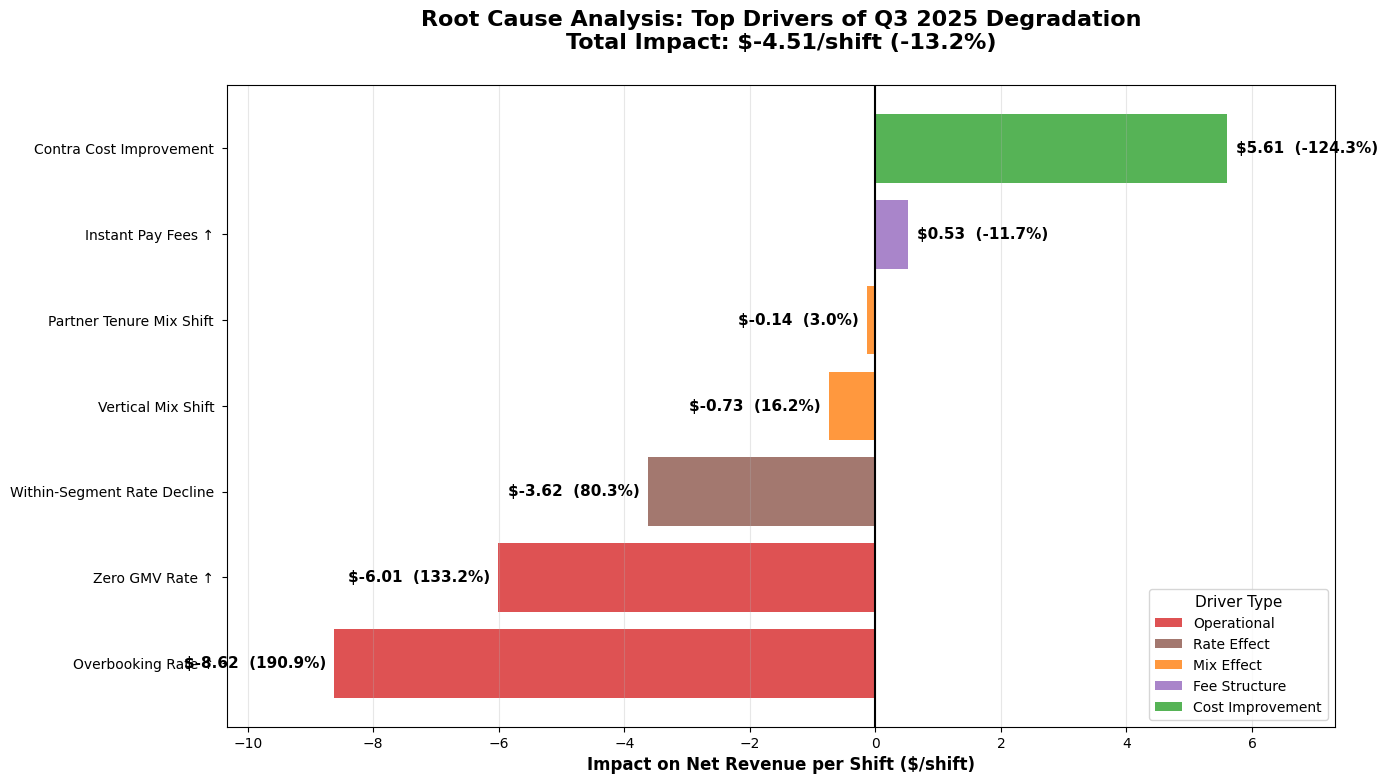


✅ Visualization saved to: ../outputs/figures/top_drivers_degradation_04.png


In [218]:
# Horizontal bar chart of top drivers with non-overlapping data labels

fig, ax = plt.subplots(figsize=(14, 8))

# Color mapping
color_map = {
    'Operational': '#d62728',      # Red
    'Mix Effect': '#ff7f0e',       # Orange
    'Rate Effect': '#8c564b',      # Brown
    'Cost Improvement': '#2ca02c', # Green
    'Fee Structure': '#9467bd'     # Purple
}

colors = [color_map[dt] for dt in driver_summary['driver_type']]

# Bars
bars = ax.barh(
    driver_summary['driver'],
    driver_summary['impact_per_shift'],
    color=colors,
    alpha=0.8
)

# Data labels with pixel offsets to avoid overlapping y-axis labels
for i, (driver, impact, pct) in enumerate(zip(
    driver_summary['driver'],
    driver_summary['impact_per_shift'],
    driver_summary['pct_of_degradation']
)):
    ha = 'left' if impact >= 0 else 'right'
    xoff = 6 if impact >= 0 else -6  # pixel offset from bar end
    ax.annotate(
        f'${impact:.2f}  ({pct:.1f}%)',
        xy=(impact, i), xytext=(xoff, 0),
        textcoords='offset points',
        va='center', ha=ha, fontsize=11, fontweight='bold',
        clip_on=False
    )

# Axes formatting
ax.set_xlabel('Impact on Net Revenue per Project ($/project)', fontsize=12, fontweight='bold')

ax.set_title(
    f'Root Cause Analysis: Top Drivers of Q3 2025 Degradation\nTotal Impact: ${total_degradation:.2f}/project (-13.2%)',
    fontsize=16, fontweight='bold', pad=26
)

ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
ax.grid(True, alpha=0.3, axis='x')

# Improve spacing: y tick label padding and horizontal margins
ax.tick_params(axis='y', pad=6)
ax.margins(x=0.12)

# Ensure room for small negative bars so labels don’t overlap category names
xmin, xmax = ax.get_xlim()
xmin = min(xmin, driver_summary['impact_per_shift'].min() - 1.0)
ax.set_xlim(xmin, xmax)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[dt], alpha=0.8, label=dt)
                   for dt in driver_summary['driver_type'].unique()]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10,
          title='Driver Type', title_fontsize=11)

plt.tight_layout()
plt.subplots_adjust(top=0.88)  # extra room for the larger, two-line title
plt.savefig('../outputs/figures/top_drivers_degradation_04.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization saved to: ../outputs/figures/top_drivers_degradation_04.png")

### 11.4 Executive Summary Table

In [219]:
executive_summary = driver_summary.copy()
executive_summary['impact_display'] = executive_summary['impact_per_shift'].apply(lambda x: f'${x:+.2f}')
executive_summary['pct_display'] = executive_summary['pct_of_degradation'].apply(lambda x: f'{x:+.1f}%')

print("\n" + "="*80)
print("EXECUTIVE SUMMARY: Root Causes of -$4.51/project Degradation (Q3 2024 → Q3 2025)")
print("="*80)
print(executive_summary[['driver', 'driver_type', 'impact_display', 'pct_display']].to_string(index=False))
print("\n" + "="*80)
print("\nKEY TAKEAWAYS:")
print("1. Operational issues (Zero GMV + Overbooking) are the largest drivers")
print("2. Within-segment rate decline indicates pricing pressure across all segments")
print("3. Mix projects toward lower-margin verticals/clients compound the problem")
print("4. Contra cost improvements partially offset, but not enough")
print("="*80)


EXECUTIVE SUMMARY: Root Causes of -$4.51/project Degradation (Q3 2024 → Q3 2025)
                     driver      driver_type impact_display pct_display
         Overbooking Rate ↑      Operational         $-8.62     +190.9%
            Zero GMV Rate ↑      Operational         $-6.01     +133.2%
Within-Segment Rate Decline      Rate Effect         $-3.62      +80.3%
         Vertical Mix Project       Mix Effect         $-0.73      +16.2%
   Client Tenure Mix Project       Mix Effect         $-0.14       +3.0%
         Instant Pay Fees ↑    Fee Structure         $+0.53      -11.7%
    Contra Cost Improvement Cost Improvement         $+5.61     -124.3%


KEY TAKEAWAYS:
1. Operational issues (Zero GMV + Overbooking) are the largest drivers
2. Within-segment rate decline indicates pricing pressure across all segments
3. Mix projects toward lower-margin verticals/clients compound the problem
4. Contra cost improvements partially offset, but not enough


In [220]:
conn.close()